# TP 1 Análisis de Series Temporales
Brusasca - Duran - Gaddi - Lijtmaer - Palavecino

<div style="border:2px solid #888; padding:20px; border-radius:10px;">

<h2 style="margin-top:0; font-size:22px;">Tabla de contenidos</h2>

<ul style="list-style-type:none; padding-left:10px; font-size:18px; line-height:1.8;">
  <li><a href="#preprocesamiento">1. Preprocesamiento y Análisis</a></li>
  <li><a href="#arima">2. ARIMA/SARIMA</a></li>
  <li><a href="#var">3. VAR</a></li>
  <li><a href="#comparativa">4. Comparativa ARIMA vs VAR</a></li>
  <li><a href="#automl">5. AutoML - Flaml</a></li>
  <li><a href="#timegpt">6. TimeGPT</a></li>

</ul>

</div>


## <span id="preprocesamiento"></span> Preprocesamiento y Análisis

### Importación de librerías necesarias para análisis de series temporales


In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, acovf
import statsmodels.api as sm 
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, normal_ad
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (11, 5)

warnings.simplefilter("ignore", ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-invertible")
warnings.filterwarnings("ignore", message="No frequency information")

### Descarga de datos financieros

Se seleccionaron los *tickers* de interés —**NVIDIA (NVDA)**, **AMD** e **Intel (INTC)**— y se descargaron sus precios de cierre ajustados desde **Yahoo Finance** para el período comprendido entre enero de 2023 y enero de 2025.  

La variable `close` contiene únicamente la serie de precios de cierre ajustados, lo que asegura la consistencia frente a dividendos y *splits*. Esta base servirá como insumo principal para los análisis posteriores de visualización, pruebas de estacionariedad y modelado de series temporales.


In [2]:
# Descarga de series de precios de cierre (NVDA, AMD, INTC)
tickers = ["NVDA", "AMD", "INTC"]

data = yf.download(
    tickers=tickers,
    start="2023-01-01",
    end="2025-01-01",
    auto_adjust=True,
    progress=False
)

close = data["Close"]

In [3]:
desc_p = close.describe().T[["mean","std","min","25%","50%","75%","max"]]
print("Descriptivos en PRECIOS (2023–2025):"); display(desc_p.round(3))

Descriptivos en PRECIOS (2023–2025):


mean     std     min      25%      50%      75%      max
Ticker                                                             
AMD     130.456  32.703  62.330  105.312  130.165  157.653  211.380
INTC     31.992   7.597  18.890   26.980   31.199   35.953   50.089
NVDA     72.307  41.144  14.252   41.933   49.771  115.405  148.837

### Estadísticos descriptivos

Se presentan los estadísticos descriptivos de los **precios de cierre ajustados** (2023–2025) para las tres compañías analizadas:

- **AMD** muestra un precio promedio de **130.46 USD**, con un rango amplio entre **62.33 y 211.38 USD**, lo que evidencia una volatilidad considerable.  
- **INTC** presenta un nivel de precios más bajo y estable, con una media de **31.99 USD** y menor dispersión relativa (desvío estándar ≈ 7.60).  
- **NVDA** registra un promedio de **72.31 USD**, destacándose por la mayor dispersión relativa (desvío estándar ≈ 41.14), lo que refleja alta variabilidad en su cotización.  

En síntesis, **AMD y NVDA se caracterizan por una dinámica más volátil**, mientras que **Intel mantiene precios más acotados**, lo que constituye un primer indicio de diferencias estructurales en el comportamiento de cada activo.


### Visualización inicial de las series de precios

Se realiza una primera exploración gráfica de los precios de cierre de las 
acciones seleccionadas (**NVDA, AMD e INTC**).  

La representación visual permite identificar **tendencias generales**, 
comparar **diferencias de nivel entre activos** y detectar 
**comportamientos comunes o disímiles** (picos, caídas o movimientos de mercado).  

Este paso exploratorio resulta esencial antes de aplicar pruebas estadísticas, 
ya que brinda una **intuición preliminar** sobre la naturaleza y dinámica de las series.

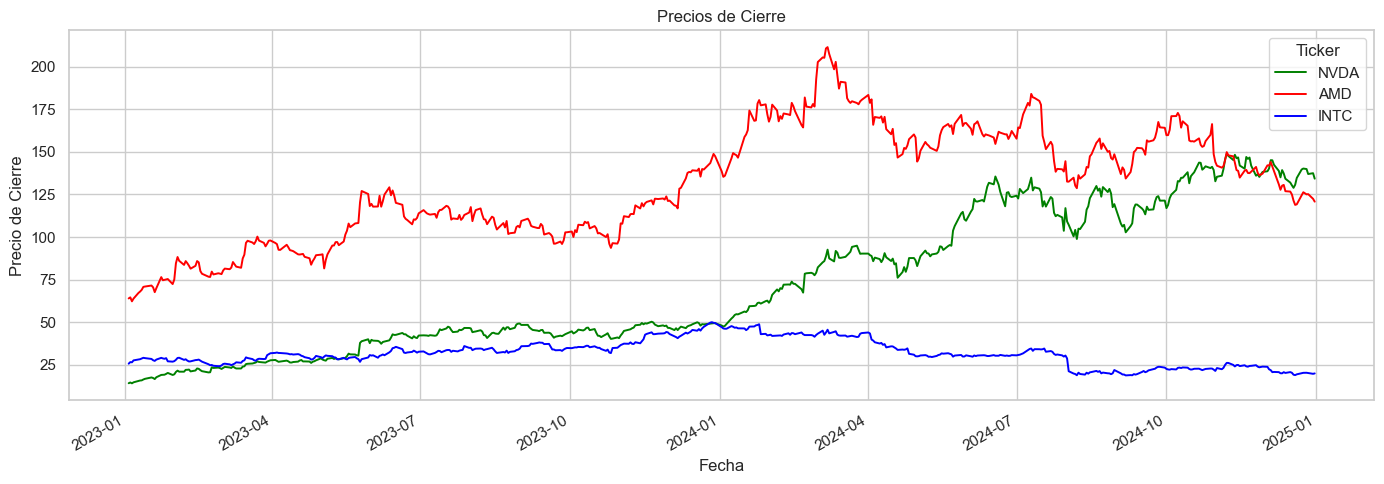

In [4]:
ax = close[["NVDA","AMD","INTC"]].plot(
    color=["green","red","blue"], lw=1.4, figsize=(14,5)
)
ax.set_title("Precios de Cierre")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio de Cierre")
ax.legend(["NVDA","AMD","INTC"], title="Ticker")
plt.tight_layout()
plt.show()


### Análisis gráfico de los precios de cierre

En la figura se presentan los precios de cierre ajustados de **NVIDIA (NVDA)**,  
**AMD (AMD)** e **Intel (INTC)** en el período comprendido entre enero de 2023 y enero de 2025.

- **AMD (rojo)**: exhibe el nivel de precios más elevado a lo largo del período, con una fuerte tendencia alcista hasta inicios de 2024, seguida de episodios de alta volatilidad y cierta corrección en la segunda mitad de 2024.  
- **NVDA (verde)**: mantiene valores intermedios, con una fase alcista marcada hasta mediados de 2024 y luego una caída significativa que se estabiliza hacia el cierre del período.  
- **INTC (azul)**: se ubica en el nivel más bajo en comparación con sus pares, aunque muestra un crecimiento progresivo hasta mediados de 2024, tras lo cual experimenta una corrección y posterior estabilización.  

Este análisis preliminar permite observar **diferencias en niveles de precios, tendencias 
y volatilidad** entre las tres acciones, lo que justifica un estudio estadístico más profundo 
para evaluar estacionariedad y dependencias temporales.

### Descomposición estacional de las series

En este bloque se aplica la **descomposición clásica aditiva** a las tres series de precios 
de cierre (NVDA, AMD e INTC) utilizando diferentes longitudes de período:  
- **21 días** (aproximadamente un mes bursátil),  
- **63 días** (trimestre),  
- **126 días** (semestre),  
- **252 días** (año bursátil).  

Cada descomposición permite observar la **tendencia**, la **estacionalidad** y los 
**residuos** de cada serie.  
Este análisis ayuda a identificar patrones recurrentes y a diferenciar el componente 
determinístico (tendencia + estacionalidad) del componente aleatorio, lo cual es 
fundamental antes de avanzar hacia modelos ARIMA o VAR.


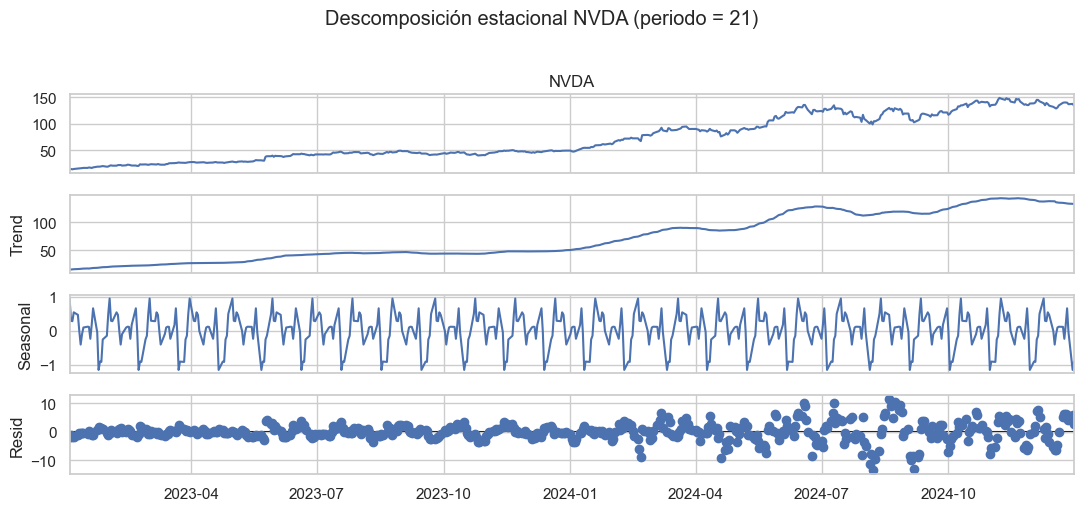

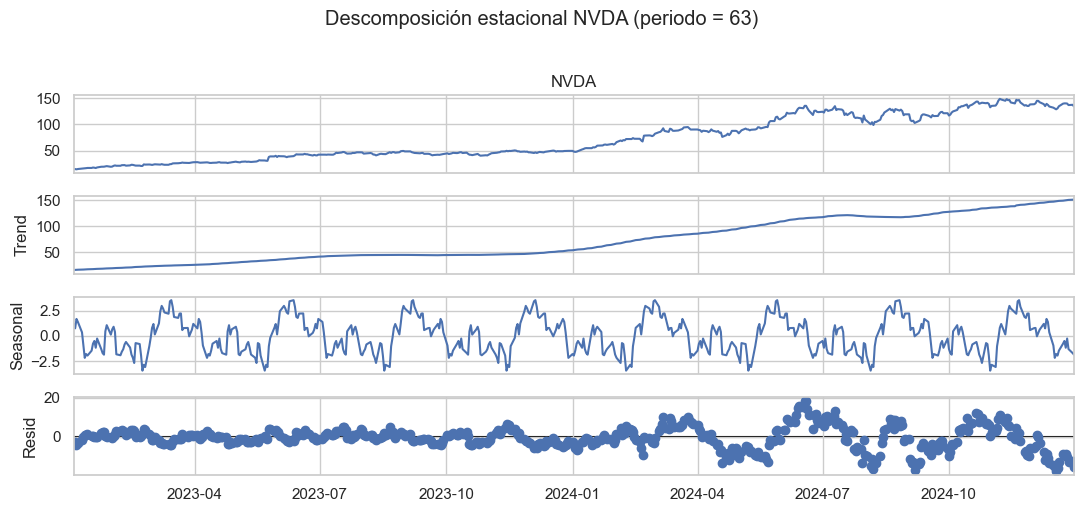

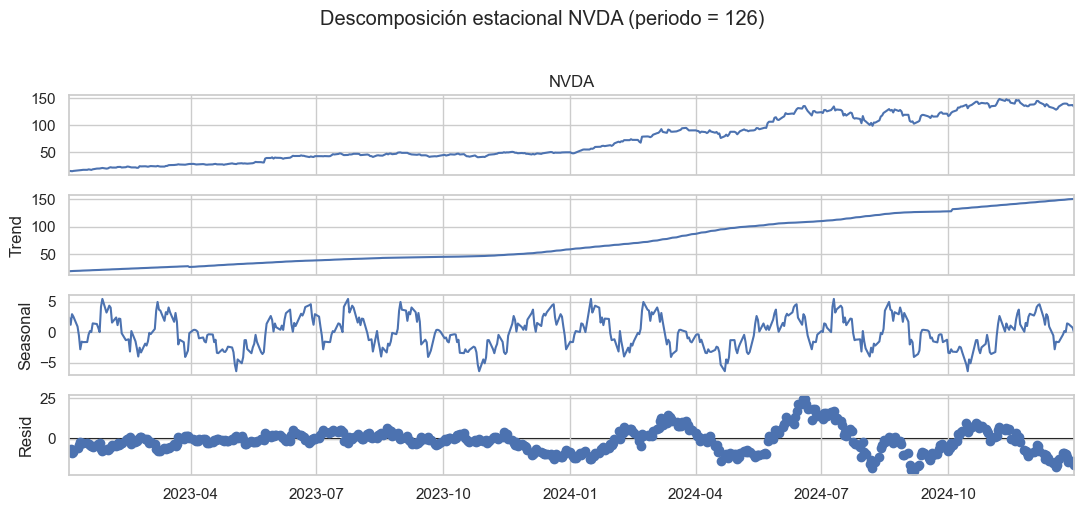

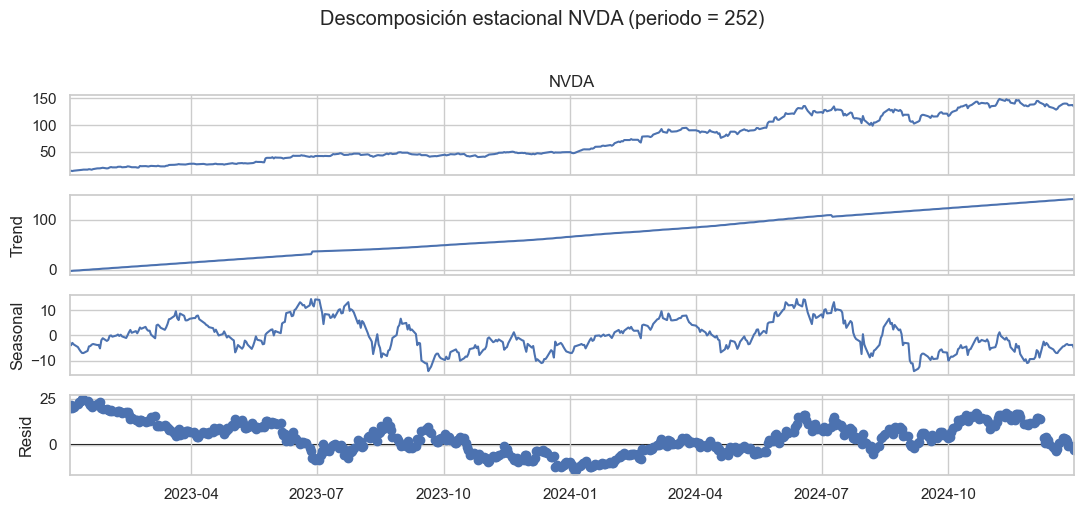

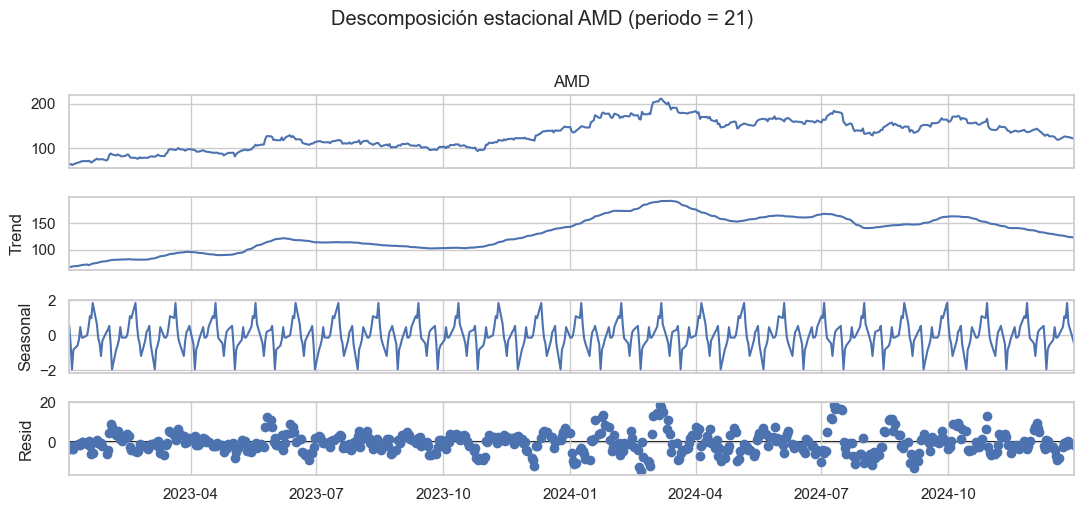

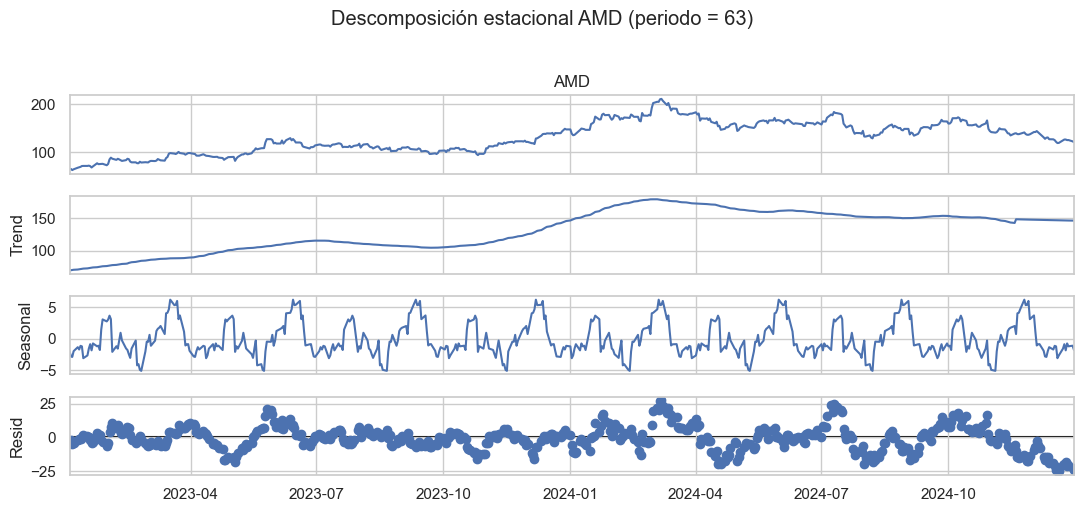

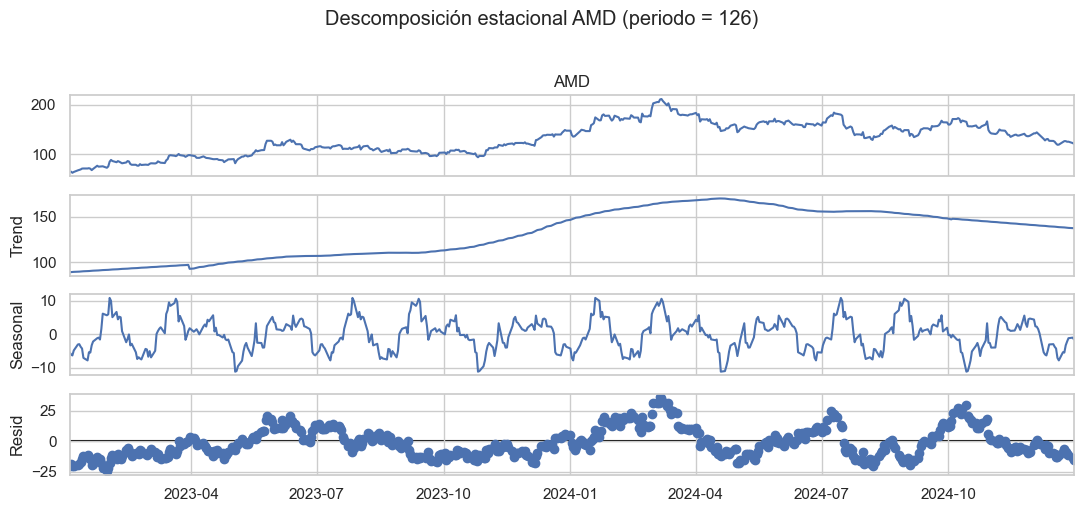

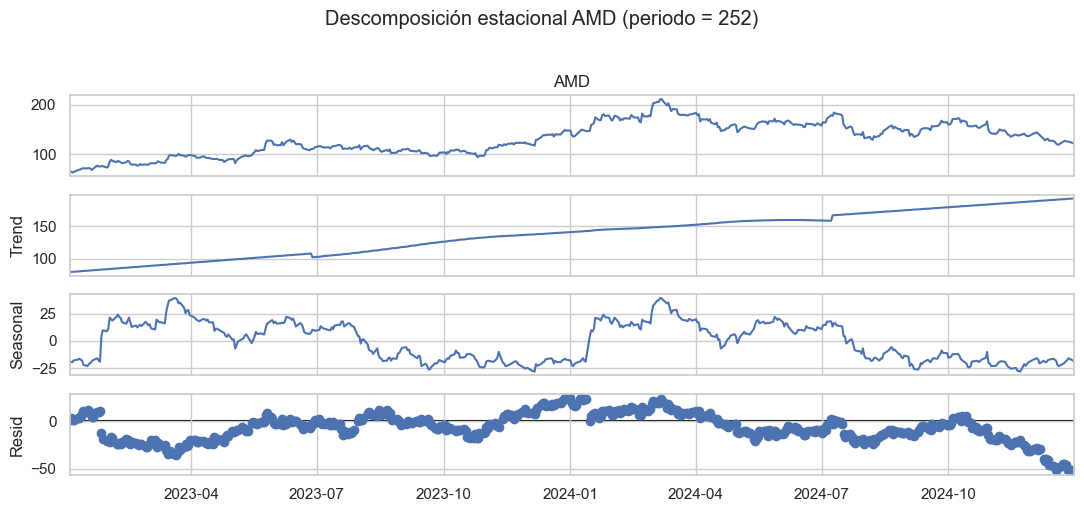

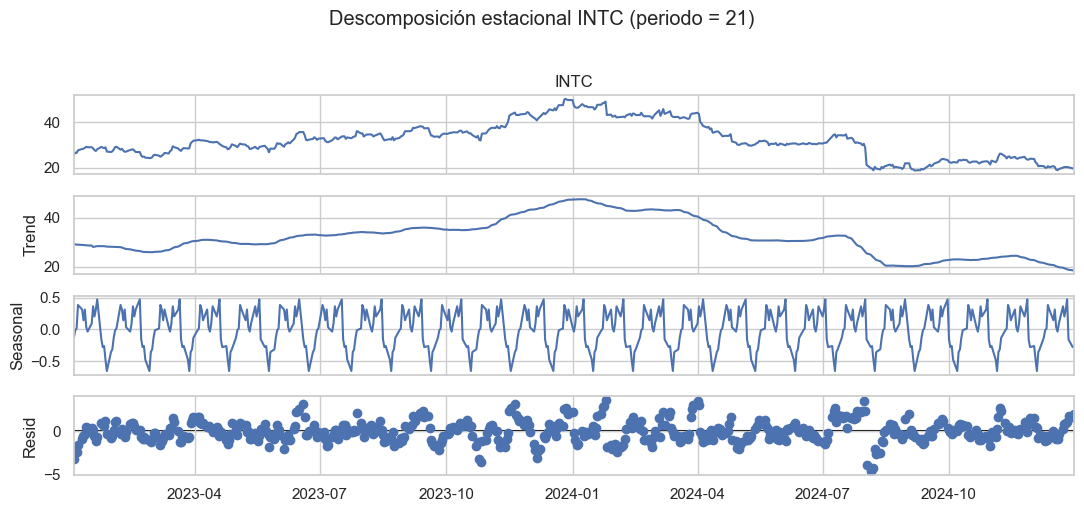

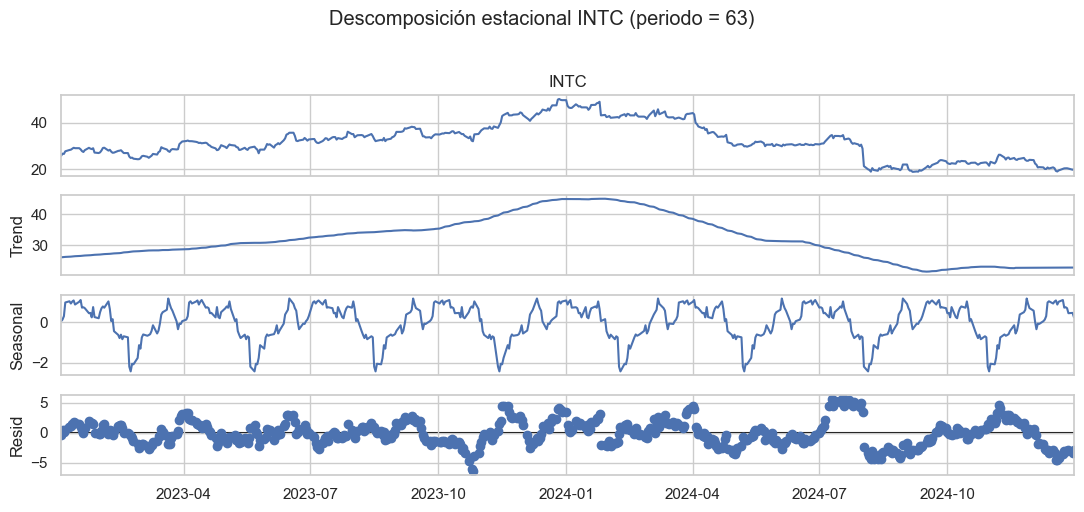

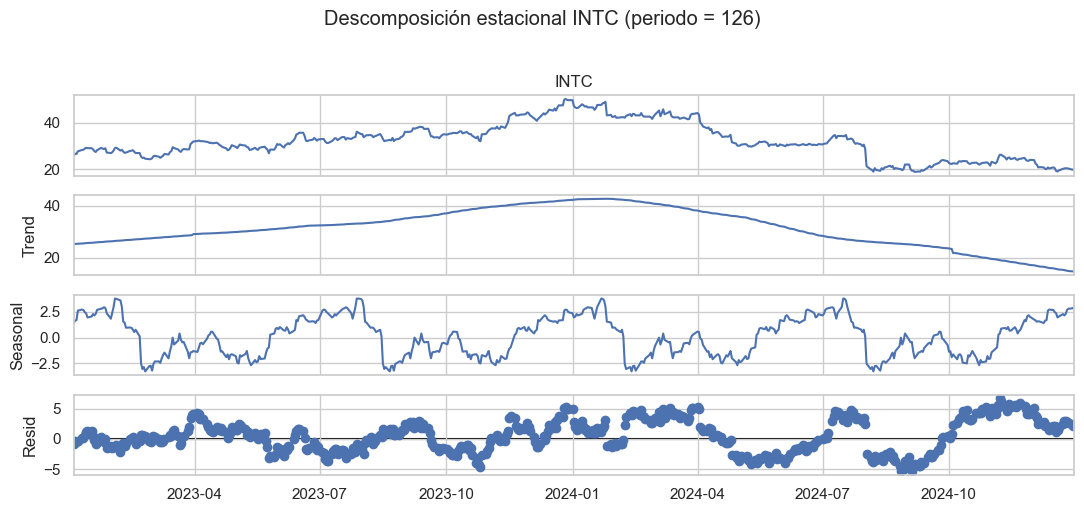

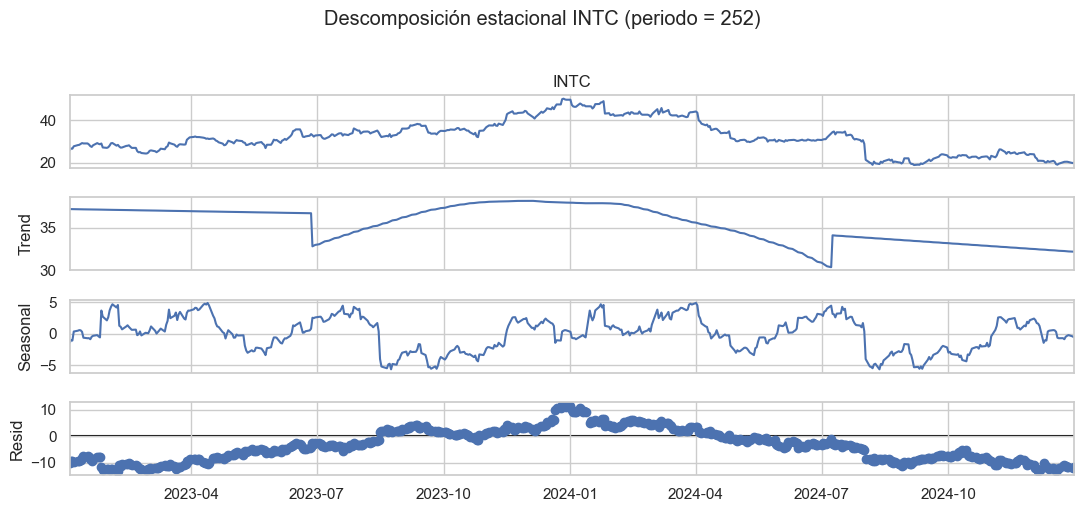

In [5]:
periods = [21, 63, 126, 252]

for tk in tickers:
    s = close[tk].dropna().asfreq("B").ffill()

    for p in periods:
        if len(s) < 2 * p:
            print(f"{tk}: se omite period={p} (requiere >= {2*p} obs; hay {len(s)}).")
            continue

        res = seasonal_decompose(s, model="additive", period=p, extrapolate_trend="freq")
        fig = res.plot()
        fig.suptitle(f"Descomposición estacional {tk} (periodo = {p})", y=1.02)
        plt.tight_layout()
        plt.show()

Análisis de la descomposición estacional

Se presentan las descomposiciones clásicas aditivas de los precios de cierre de **NVIDIA (NVDA)**,  
**AMD (AMD)** e **Intel (INTC)** considerando distintos períodos bursátiles:  
- **21 días** ≈ 1 mes  
- **63 días** ≈ 1 trimestre  
- **126 días** ≈ 1 semestre  
- **252 días** ≈ 1 año  

**Componente de Tendencia (Trend):**  
- En las tres acciones se observa una tendencia **alcista** a lo largo de 2023 e inicios de 2024, con distintos matices:  
  - **NVDA:** crecimiento más pronunciado, alcanzando picos hacia mediados de 2024.  
  - **AMD:** tendencia positiva aunque más moderada, con retrocesos a finales de 2024.  
  - **INTC:** aumento en la primera mitad del período, pero luego una caída clara a partir de 2024.  
- A medida que aumenta el período, la tendencia se suaviza y captura mejor la dirección general de largo plazo.

**Componente Estacional (Seasonal):**  
- Con **períodos cortos (21 días)** se detectan ciclos de alta frecuencia (variaciones mensuales o semanales en el mercado).  
- Con **períodos medios (63 y 126 días)** surgen patrones más amplios, que reflejan movimientos trimestrales o semestrales, relacionados con reportes de resultados o coyuntura sectorial.  
- Con **período largo (252 días)** se destacan oscilaciones anuales, que muestran comportamientos repetitivos a gran escala.  
- En general, la estacionalidad es más visible en **NVDA y AMD**, mientras que en **INTC** los patrones estacionales son más débiles y están opacados por la caída de tendencia.

**Componente de Residuos (Resid):**  
- Los residuos concentran la **volatilidad no explicada** por la tendencia ni por la estacionalidad.  
- Presentan picos coincidentes con eventos de mercado o shocks inesperados (ej. subas/bajas abruptas).  
- En las tres acciones se observa que los residuos oscilan en torno a cero, lo que sugiere que la descomposición captura adecuadamente la estructura principal de las series.  
- No obstante, la dispersión es más marcada en NVDA (alta volatilidad asociada al sector tecnológico) que en INTC (más estable en sus fluctuaciones, salvo la caída fuerte de 2024).

La descomposición muestra que los precios de NVDA, AMD e INTC tienen componentes de **tendencia creciente en 2023 e inicios de 2024**, acompañados de patrones **estacionales dependientes del horizonte** y residuos que reflejan la fuerte exposición del sector tecnológico a shocks externos.  
Estos resultados sugieren que, para modelado, será necesario trabajar con técnicas como **ARIMA/SARIMA o VAR**, tras aplicar diferenciación o transformaciones que permitan garantizar la estacionariedad.

### Serie original, FAS, FAC y FACP

Se analizan las tres series (NVDA, AMD e INTC) junto con sus:

- **Serie original**: permite observar el comportamiento temporal crudo.  
- **FAS (Función de Autocovarianza Muestral)**: mide la covarianza de la serie con sus propios rezagos. Es la base para calcular la FAC.  
- **FAC (Función de Autocorrelación, ACF)**: muestra qué tan correlacionada está la serie consigo misma en distintos rezagos, lo cual es útil para detectar persistencia temporal (procesos AR, MA o mixtos).  
- **FACP (Función de Autocorrelación Parcial, PACF)**: permite identificar el orden de los procesos autoregresivos (AR), ya que mide la correlación neta de cada rezago una vez controlados los anteriores.  

Este análisis preliminar es esencial para orientar la elección de modelos ARIMA/SARIMA, 
pues facilita la determinación de los órdenes **p** (autoregresivo) y **q** (media móvil).

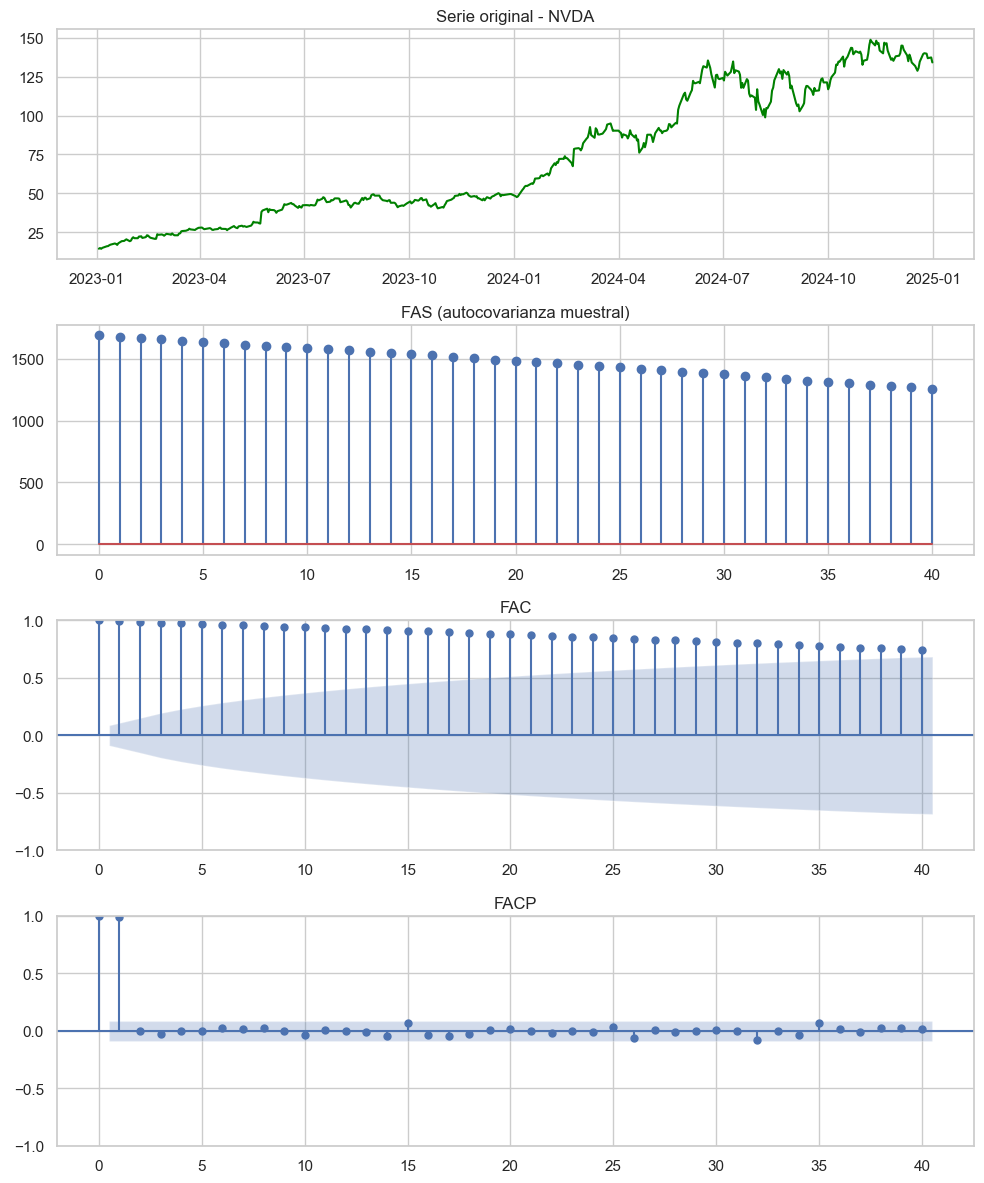

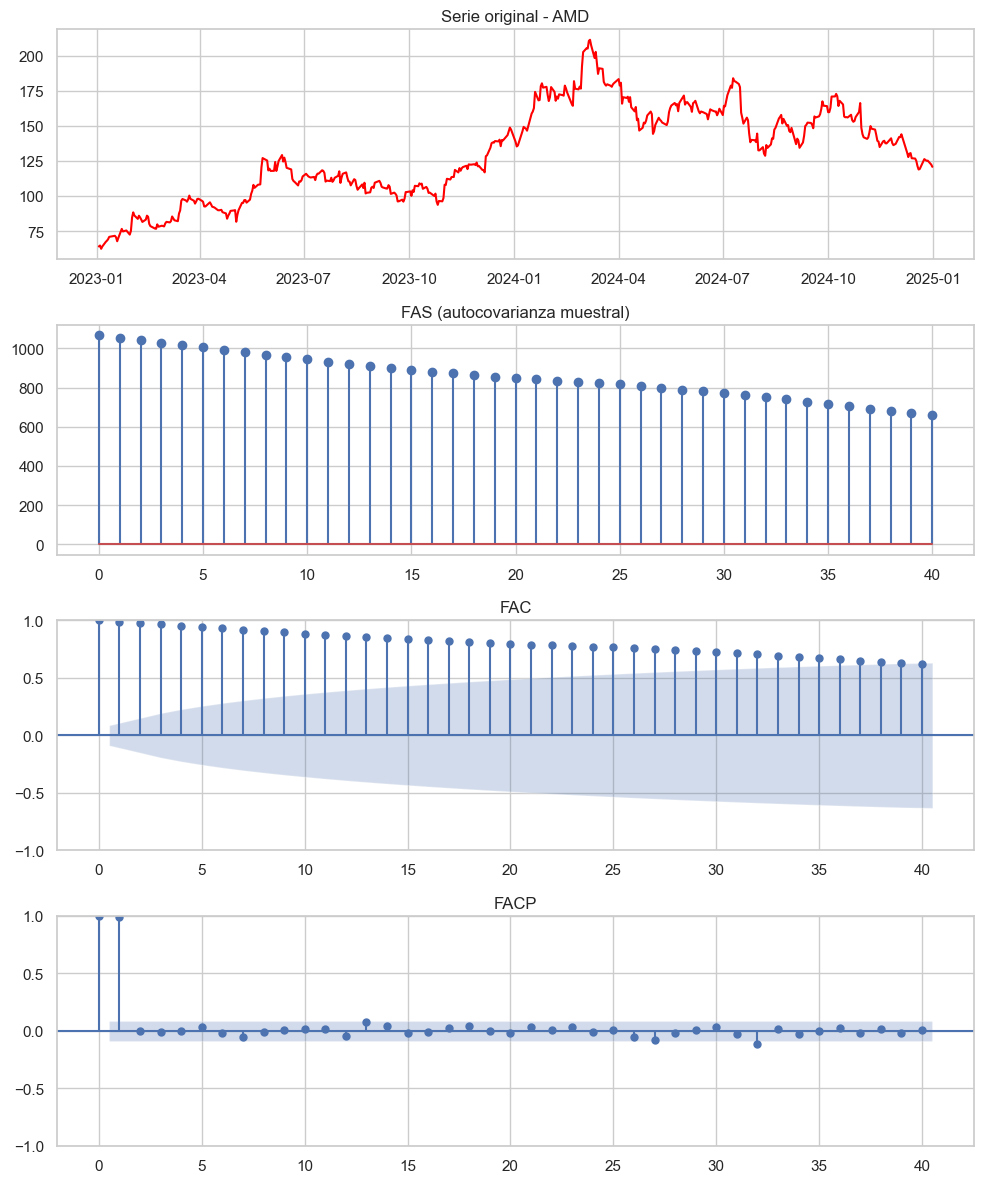

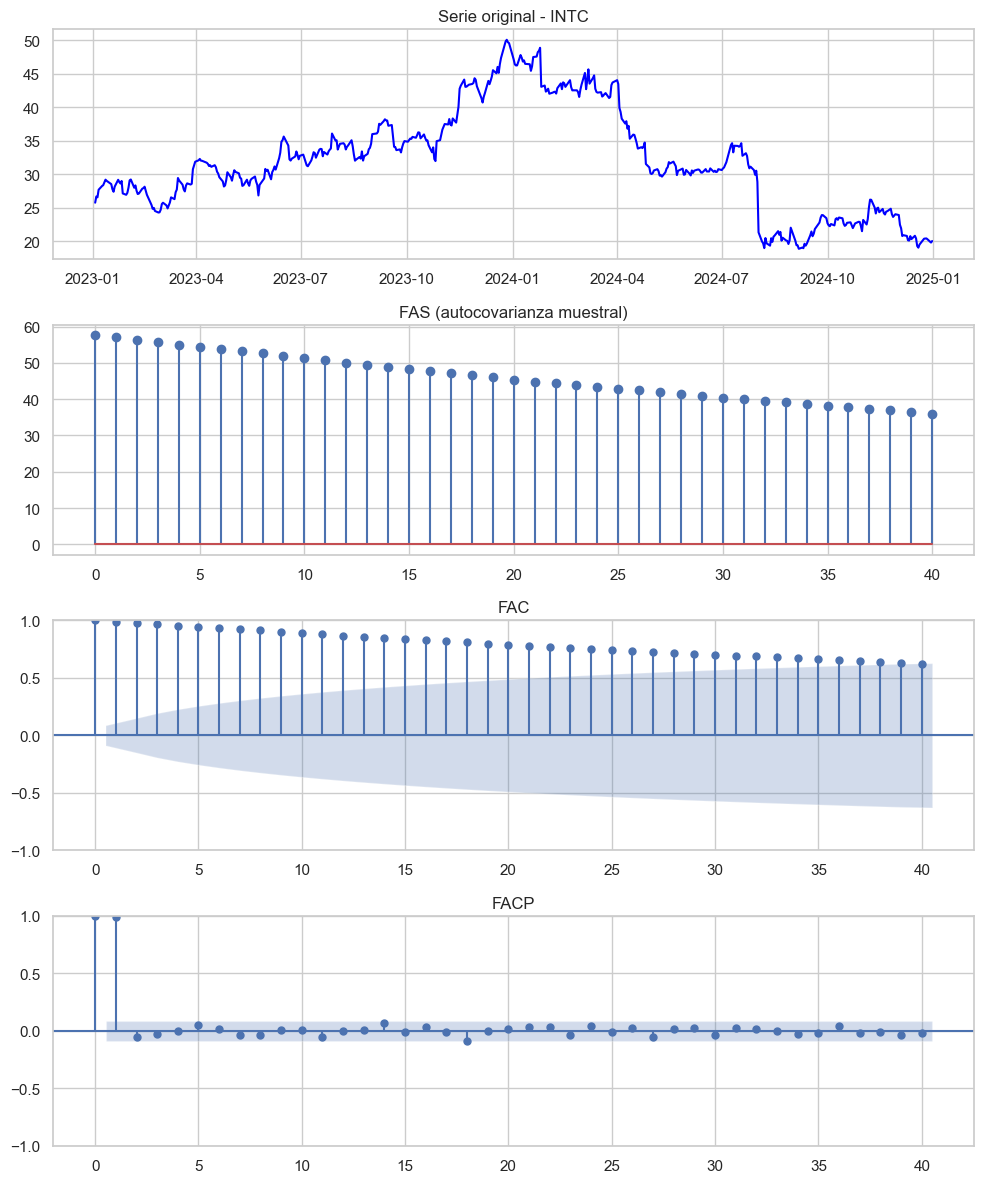

In [6]:
nvda_close = close['NVDA'].dropna()
amd_close  = close['AMD'].dropna()
intel_close= close['INTC'].dropna()

def plot_fas_fac_facp(serie, titulo, color):
    fig, axes = plt.subplots(4, 1, figsize=(10, 12))

    axes[0].plot(serie, color=color)
    axes[0].set_title(f"Serie original - {titulo}")

    acvf = acovf(serie - serie.mean(), fft=True, nlag=40)
    axes[1].stem(range(len(acvf)), acvf)
    axes[1].set_title("FAS (autocovarianza muestral)")

    plot_acf(serie, ax=axes[2], lags=40)
    axes[2].set_title("FAC")

    plot_pacf(serie, ax=axes[3], lags=40, method='ywm')
    axes[3].set_title("FACP")

    plt.tight_layout(); plt.show()

plot_fas_fac_facp(nvda_close, "NVDA", "green")
plot_fas_fac_facp(amd_close,  "AMD",  "red")
plot_fas_fac_facp(intel_close,"INTC", "blue")

### Análisis de la serie original, FAS, FAC y FACP

Se muestran los gráficos de las series originales de precios de **NVDA, AMD e INTC**, 
junto con sus **funciones de autocovarianza (FAS)**, **autocorrelación (FAC)** y 
**autocorrelación parcial (FACP)**.

**Serie original**  
- Todas las series presentan una **tendencia clara** (creciente en NVDA y AMD hasta 2024; 
  con caídas marcadas en INTC a partir de mediados de 2024).  
- Esto indica que las series **no son estacionarias**, ya que su media varía en el tiempo.

**Función de Autocovarianza Muestral (FAS)**  
- La FAS refleja covarianzas muy altas en los primeros rezagos y decrece lentamente.  
- Este patrón confirma la **fuerte dependencia temporal** de las observaciones pasadas 
  sobre las presentes.

**Función de Autocorrelación (FAC)**  
- La FAC muestra valores positivos muy altos y persistentes en todos los rezagos, 
  con una desaceleración muy lenta.  
- Este patrón es típico de una **serie con tendencia o caminata aleatoria**, donde 
  las correlaciones no decaen rápidamente hacia cero.  
- Es un signo claro de **no estacionariedad en nivel**.

**Función de Autocorrelación Parcial (FACP)**  
- En las tres series, la FACP presenta un **pico muy alto en el primer rezago (lag 1)** 
  y luego se estabiliza cerca de cero.  
- Este comportamiento es característico de un **proceso AR(1) no estacionario** 
  o de una caminata aleatoria, donde el primer rezago explica prácticamente toda 
  la dependencia temporal.


- Las tres acciones muestran **fuerte persistencia temporal**, lo que implica que shocks pasados 
  siguen influyendo en el futuro.  
- Es necesario aplicar **transformaciones (como la diferenciación)** para eliminar la tendencia 
  y lograr estacionariedad.  
- La evidencia de FAS, FAC y FACP sugiere que, tras la diferenciación, podrían modelarse 
  con un ARIMA de bajo orden (ejemplo: ARIMA(1,1,0) o ARIMA(0,1,1)), hipótesis que debe validarse 
  con pruebas de estacionariedad (ADF, KPSS) y comparaciones de modelos.


### Prueba de raíz unitaria ADF (Augmented Dickey-Fuller)

Se aplica la prueba de **Dickey-Fuller aumentada (ADF)** para evaluar 
la **estacionariedad** de las series de precios de NVDA, AMD e INTC.  

- **Hipótesis nula (H₀):** la serie tiene raíz unitaria (es **no estacionaria**).  
- **Hipótesis alternativa (H₁):** la serie es **estacionaria**.  

La decisión se toma en base al **p-value**:  
- Si `p ≤ 0.05` → se rechaza H₀ → la serie es estacionaria.  
- Si `p > 0.05` → no se rechaza H₀ → la serie no es estacionaria.  

Dado el comportamiento observado en las gráficas y en las funciones de autocorrelación, 
se espera que las tres series **no sean estacionarias en nivel**, lo cual confirmará la necesidad 
de diferenciarlas antes de modelar con ARIMA/SARIMA o VAR.


In [7]:
def adf_test(timeseries, nombre):
    result = adfuller(timeseries.dropna(), autolag='AIC')
    print(f"\nADF Test para la serie: {nombre}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("La serie es estacionaria (rechazamos H0)")
    else:
        print("La serie NO es estacionaria (no rechazamos H0)")

adf_test(nvda_close, "NVDA")
adf_test(amd_close, "AMD")
adf_test(intel_close, "INTC")


ADF Test para la serie: NVDA
ADF Statistic: -0.3709177548507197
p-value: 0.9148424058910329
La serie NO es estacionaria (no rechazamos H0)

ADF Test para la serie: AMD
ADF Statistic: -2.117530211645875
p-value: 0.2375242886408263
La serie NO es estacionaria (no rechazamos H0)

ADF Test para la serie: INTC
ADF Statistic: -1.0938345424098441
p-value: 0.7175243450394616
La serie NO es estacionaria (no rechazamos H0)


Resultados de la prueba ADF

Los resultados del test de **Dickey-Fuller aumentado (ADF)** para las series de precios son:

- **NVDA**  
  - Estadístico ADF: -0.37  
  - p-value: 0.915  
  - **Conclusión:** no se rechaza H₀ → la serie **no es estacionaria**.

- **AMD**  
  - Estadístico ADF: -2.12  
  - p-value: 0.238  
  - **Conclusión:** no se rechaza H₀ → la serie **no es estacionaria**.

- **INTC**  
  - Estadístico ADF: -1.09  
  - p-value: 0.718  
  - **Conclusión:** no se rechaza H₀ → la serie **no es estacionaria**.
 
Las tres series presentan valores de p muy superiores al umbral del 5%, lo que confirma 
que los precios de NVDA, AMD e INTC en nivel **no son estacionarios**.  
Esto era consistente con lo observado previamente en las gráficas de FAC/FACP, donde 
se detectaba persistencia temporal y posible raíz unitaria.  
 
Antes de aplicar modelos ARIMA/SARIMA o VAR, será necesario **diferenciar las series** 
(o aplicar transformaciones adicionales) para lograr estacionariedad y cumplir 
los supuestos de los modelos.


### Prueba de estacionariedad KPSS (Kwiatkowski–Phillips–Schmidt–Shin)

La **KPSS** complementa al **ADF** para evaluar **estacionariedad**, ya que sus hipótesis nulas son **opuestas**.

**Hipótesis**
- **H₀ (KPSS):** la serie es **estacionaria**  
  - Con `regression='c'`: estacionaria alrededor de un **nivel**.  
  - Con `regression='ct'`: estacionaria alrededor de una **tendencia determinista**.  
- **H₁ (KPSS):** la serie es **no estacionaria** (tiene componente estocástica no estacionaria).

**Regla de decisión**
- Si `p-value > 0.05` → **no** se rechaza H₀ → **estacionaria**.  
- Si `p-value ≤ 0.05` → **se rechaza** H₀ → **no estacionaria**.

**Lectura conjunta con ADF**
- Si **ADF no rechaza H₀** (raíz unitaria) **y** **KPSS rechaza H₀** (no estacionaria), ambas pruebas **coinciden**: la serie **no es estacionaria**.  
- En ese caso, suele ser necesario **diferenciar** (o usar **retornos logarítmicos**) antes del modelado.

In [8]:
def kpss_test(timeseries, nombre, regression='c'):
    statistic, p_value, _, _ = kpss(timeseries.dropna(), regression=regression, nlags="auto")
    print(f"\nKPSS Test para la serie: {nombre} ")
    print(f"Statistic: {statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    if p_value > 0.05:
        print("La serie es estacionaria (no rechazamos H0)")
    else:
        print("La serie NO es estacionaria (rechazamos H0)")

kpss_test(nvda_close, "NVDA")
kpss_test(amd_close, "AMD")
kpss_test(intel_close, "INTC")

kpss_test(nvda_close, "NVDA", regression='ct')
kpss_test(amd_close,  "AMD",  regression='ct')
kpss_test(intel_close,"INTC",  regression='ct')


KPSS Test para la serie: NVDA 
Statistic: 3.7643
p-value: 0.0100
La serie NO es estacionaria (rechazamos H0)

KPSS Test para la serie: AMD 
Statistic: 2.6268
p-value: 0.0100
La serie NO es estacionaria (rechazamos H0)

KPSS Test para la serie: INTC 
Statistic: 1.0299
p-value: 0.0100
La serie NO es estacionaria (rechazamos H0)

KPSS Test para la serie: NVDA 
Statistic: 0.5252
p-value: 0.0100
La serie NO es estacionaria (rechazamos H0)

KPSS Test para la serie: AMD 
Statistic: 0.5135
p-value: 0.0100
La serie NO es estacionaria (rechazamos H0)

KPSS Test para la serie: INTC 
Statistic: 0.8349
p-value: 0.0100
La serie NO es estacionaria (rechazamos H0)


/var/folders/4r/91txlfcx43g86h5_v2czs54h0000gn/T/ipykernel_95517/227270540.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(timeseries.dropna(), regression=regression, nlags="auto")
/var/folders/4r/91txlfcx43g86h5_v2czs54h0000gn/T/ipykernel_95517/227270540.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(timeseries.dropna(), regression=regression, nlags="auto")
/var/folders/4r/91txlfcx43g86h5_v2czs54h0000gn/T/ipykernel_95517/227270540.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(timeseries.dropna(), regression=regres

### Resultados de la prueba KPSS

A continuación se presentan los resultados de **KPSS** para NVDA, AMD e INTC, primero con **`regression='c'` (nivel)** y luego con **`regression='ct'` (tendencia determinista)**. En todos los casos el **p-value reportado** es **0.0100** (límite inferior de la tabla), por lo que **se rechaza H₀**.

#### KPSS con `c` (nivel)
- **NVDA**  
  - Estadístico: **3.7643**  
  - p-value: **0.0100**  
  - **Conclusión:** se rechaza H₀ → la serie **no es estacionaria**.

- **AMD**  
  - Estadístico: **2.6268**  
  - p-value: **0.0100**  
  - **Conclusión:** se rechaza H₀ → la serie **no es estacionaria**.

- **INTC**  
  - Estadístico: **1.0299**  
  - p-value: **0.0100**  
  - **Conclusión:** se rechaza H₀ → la serie **no es estacionaria**.

#### KPSS con `ct` (tendencia determinista)
- **NVDA**  
  - Estadístico: **0.5252**  
  - p-value: **0.0100**  
  - **Conclusión:** se rechaza H₀ → la serie **no es estacionaria** (ni siquiera estacionaria alrededor de tendencia).

- **AMD**  
  - Estadístico: **0.5135**  
  - p-value: **0.0100**  
  - **Conclusión:** se rechaza H₀ → la serie **no es estacionaria**.

- **INTC**  
  - Estadístico: **0.8349**  
  - p-value: **0.0100**  
  - **Conclusión:** se rechaza H₀ → la serie **no es estacionaria**.

**Advertencia (InterpolationWarning):**  
El estadístico excede el rango tabulado para interpolar p-values, por eso la librería devuelve un **límite inferior** (≈ **0.01**). El **p-value real es aún menor**, lo que **refuerza** la evidencia contra la estacionariedad. Este warning **no invalida** el test.


### Interpretación conjunta (ADF + KPSS)

- **ADF:** no rechaza H₀ → presencia de **raíz unitaria** → **no estacionarias**.  
- **KPSS (c y ct):** rechaza H₀ → **no estacionarias** (ni alrededor de nivel ni de tendencia).

**Conclusión:** ambas pruebas, con hipótesis nulas **opuestas**, llegan a la **misma** inferencia: los **precios de NVDA, AMD e INTC no son estacionarios en nivel**.


### Implicancia para el modelado

Antes de ajustar **ARIMA/SARIMA** o **VAR**, es necesario **diferenciar** (al menos una vez) o trabajar con **retornos logarítmicos** para garantizar **estacionariedad**. Luego, diagnosticar la estacionariedad en los **residuos** de los modelos.



Test KPSS y ADF indican que las series son no estacionarias

### Partición temporal 80/20 en las series

Para evaluar la capacidad predictiva de los modelos, se dividen las series de precios de **NVDA, AMD e INTC** en dos subconjuntos:  

- **Train (80%)**: datos iniciales usados para estimar los modelos.  
- **Test (20%)**: datos más recientes, reservados para validar el desempeño fuera de muestra.  

La división se realiza de manera **cronológica**, sin mezclar observaciones, lo que garantiza que el modelo solo utilice información pasada para predecir valores futuros.  
Este procedimiento evita el *data leakage* y replica un escenario real de predicción.


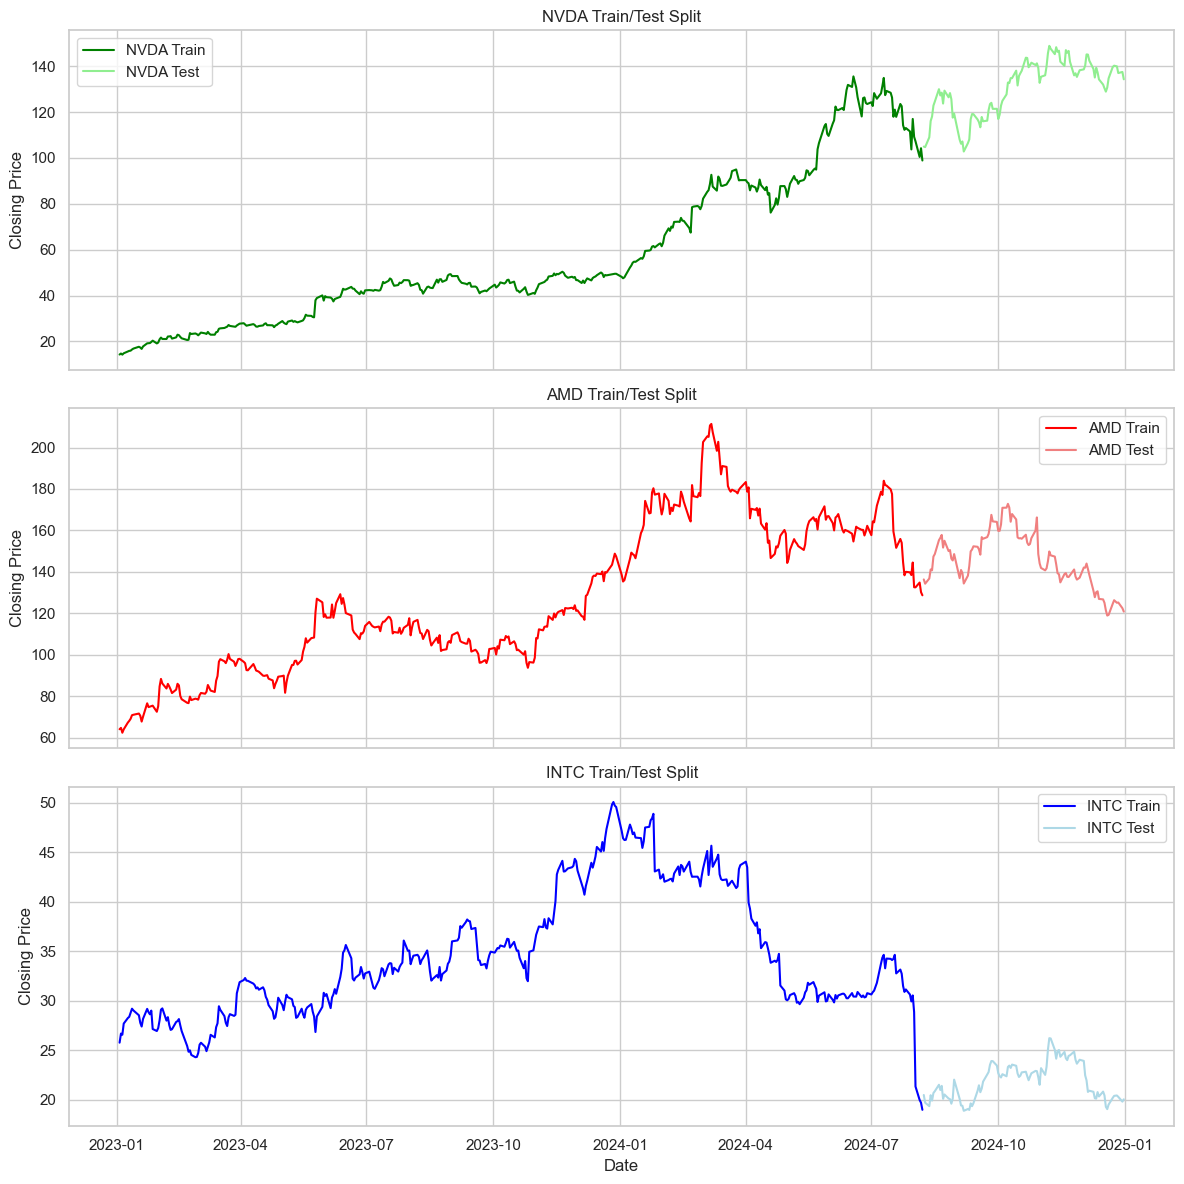

In [9]:
def time_split(s, train_size=0.8):
    s = s.sort_index()
    n = int(len(s) * train_size)
    return s.iloc[:n], s.iloc[n:]

nvda_train, nvda_test  = time_split(nvda_close, 0.8)
amd_train,  amd_test   = time_split(amd_close, 0.8)
intel_train, intel_test = time_split(intel_close, 0.8)

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

axes[0].plot(nvda_train, label="NVDA Train", color="green")
axes[0].plot(nvda_test,  label="NVDA Test",  color="lightgreen")
axes[0].set_title("NVDA Train/Test Split"); axes[0].legend()

axes[1].plot(amd_train, label="AMD Train", color="red")
axes[1].plot(amd_test,  label="AMD Test",  color="lightcoral")
axes[1].set_title("AMD Train/Test Split"); axes[1].legend()

axes[2].plot(intel_train, label="INTC Train", color="blue")
axes[2].plot(intel_test,  label="INTC Test",  color="lightblue")
axes[2].set_title("INTC Train/Test Split"); axes[2].legend()

for ax in axes:
    ax.set_ylabel("Closing Price")
axes[-1].set_xlabel("Date")

plt.tight_layout(); plt.show()

Análisis de la partición Train/Test (80/20)

En los gráficos se muestra la división temporal de cada serie de precios (**NVDA, AMD e INTC**) en un 80% para entrenamiento (**Train**) y un 20% para prueba (**Test**):

- **NVDA (verde):**  
  - La partición conserva la marcada tendencia alcista observada desde 2023, con subidas significativas durante 2024.  
  - El conjunto de prueba (última parte, en verde claro) incluye un período de elevada volatilidad, ideal para evaluar la capacidad predictiva del modelo en escenarios de fluctuaciones.

- **AMD (rojo):**  
  - La serie también muestra un fuerte crecimiento hasta principios de 2024, seguido de una corrección y oscilaciones más irregulares.  
  - El tramo de prueba contiene esta fase de ajuste y resulta útil para contrastar si el modelo logra adaptarse a cambios de tendencia.

- **INTC (azul):**  
  - Presenta una tendencia ascendente hasta principios de 2024, pero posteriormente experimenta una caída sostenida.  
  - El conjunto de prueba refleja este proceso de descenso, lo cual exigirá a los modelos capturar no solo crecimientos sino también retrocesos.

La partición temporal aplicada (80/20) asegura que los modelos sean entrenados con la mayor parte del historial disponible y validados sobre los datos más recientes. Esto permite evaluar de forma realista su capacidad para predecir en distintos escenarios de mercado:  
- **crecimientos fuertes (NVDA, AMD),**  
- **correcciones y caídas (AMD, INTC),**  
- **alta volatilidad (NVDA).**  

Este tipo de validación es fundamental para verificar que las predicciones no solo ajusten el pasado, sino que también sean robustas frente a nuevas dinámicas en los precios.

## <span id="arima"></span> ARIMA/SARIMA

### Selección automática de modelos ARIMA/SARIMA (AutoARIMA)

Dentro del enfoque **Box–Jenkins**, la identificación de órdenes para modelos ARIMA/SARIMA constituye una de las etapas más desafiantes.  
Para resolver esta tarea de forma eficiente se recurre a la función **`auto_arima`** de la librería `pmdarima`, la cual implementa un procedimiento de búsqueda automatizado que compara múltiples especificaciones de modelos y selecciona la más adecuada según un **criterio de información** (en este caso, el **AIC**).

- Se exploraron combinaciones de órdenes autorregresivos (**p**) y de medias móviles (**q**) hasta un máximo de 3.  
- Para los componentes estacionales (**P, Q**) se estableció un máximo de 2 rezagos, considerando una periodicidad de `m=21` días hábiles (aproximación a un ciclo mensual bursátil).  
- Los parámetros de diferenciación (`d` y `D`) fueron determinados automáticamente a partir de pruebas de raíces unitarias.  
- El argumento `seasonal=True` permitió incluir componentes SARIMA en la búsqueda.  
- La opción `stepwise=True` agilizó la búsqueda reduciendo la complejidad computacional.  

El procedimiento devolvió, para cada serie (NVDA, AMD e INTC), la especificación de modelo **ARIMA/SARIMA** que minimiza el **AIC**. El `summary()` de cada ajuste reporta:
- El orden identificado \((p,d,q)(P,D,Q)_{m}\).  
- Los coeficientes estimados y su significancia estadística.  
- Indicadores de bondad de ajuste: log-likelihood, AIC, BIC y HQIC.

In [10]:
nvda_train = nvda_train.asfreq("B").ffill()
amd_train  = amd_train.asfreq("B").ffill()
intel_train = intel_train.asfreq("B").ffill()

In [11]:
train_series = {
    "NVDA": nvda_train,
    "AMD": amd_train,
    "INTC": intel_train
}

auto_params = dict(
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    m=21,               
    seasonal=True,
    d=None, D=None,      
    trace=True,           
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic"
)


models = {}

for name, y_train in train_series.items():
    print(f"AutoARIMA para {name}")
    model = pm.auto_arima(y_train, **auto_params)
    models[name] = model
    print(model.summary())


print("\nResumen de órdenes seleccionados y AIC:")
for name, model in models.items():
    order = model.order
    sorder = model.seasonal_order
    aic = model.aic()
    print(f"  {name}: ARIMA{order} x SARIMA{sorder} [m=21]  |  AIC = {aic:.2f}")

AutoARIMA para NVDA
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[21] intercept   : AIC=1849.990, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[21] intercept   : AIC=1844.243, Time=1.34 sec
 ARIMA(0,1,1)(0,0,1)[21] intercept   : AIC=1843.430, Time=2.63 sec
 ARIMA(0,1,0)(0,0,0)[21]             : AIC=1851.448, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[21] intercept   : AIC=1844.036, Time=0.11 sec
 ARIMA(0,1,1)(1,0,1)[21] intercept   : AIC=1845.351, Time=2.25 sec
 ARIMA(0,1,1)(0,0,2)[21] intercept   : AIC=1845.236, Time=24.34 sec
 ARIMA(0,1,1)(1,0,0)[21] intercept   : AIC=1843.357, Time=0.68 sec
 ARIMA(0,1,1)(2,0,0)[21] intercept   : AIC=1845.342, Time=25.66 sec
 ARIMA(0,1,1)(2,0,1)[21] intercept   : AIC=inf, Time=59.40 sec
 ARIMA(0,1,0)(1,0,0)[21] intercept   : AIC=1848.640, Time=0.56 sec
 ARIMA(1,1,1)(1,0,0)[21] intercept   : AIC=1844.818, Time=1.53 sec
 ARIMA(0,1,2)(1,0,0)[21] intercept   : AIC=1844.529, Time=1.10 sec
 ARIMA(1,1,2)(1,0,0)[21] intercept   : AIC=1846.500, Time=4.87 sec
 

Resultados de AutoARIMA para NVDA, AMD e INTC

Tras aplicar el procedimiento de selección automática de modelos SARIMA con `auto_arima`, se obtuvieron los siguientes resultados para cada serie temporal:

#### NVDA
- **Modelo seleccionado:** ARIMA(0,1,1) × (1,0,0)[21]  
- **Criterio de información:** AIC = **1843.36** (menor valor comparado con los candidatos).  
  - Requirió **una diferenciación no estacional (d=1)** para lograr estacionariedad.  
  - Incluye un término de medias móviles (**MA(1)**) en la parte regular.  
  - En la parte estacional (m=21 días hábiles), se identificó un rezago autorregresivo (**SAR(1)**).  
  - Los coeficientes principales resultaron estadísticamente significativos (p < 0.05).  
  - Los test de residuos muestran **cierta heterocedasticidad** y **no normalidad**, y autocorrelación a rezagos bajos (Ljung–Box con p<0.05 en lag 1).  
Se trata de un modelo **SARIMA complejo pero adecuado** para capturar la estacionalidad mensual bursátil de NVDA, útil para establecer un punto de partida en el análisis.

#### AMD
- **Modelo seleccionado:** ARIMA(0,1,0) (modelo de **paseo aleatorio**).  
- **Criterio de información:** AIC = **2249.26**.  
  - La serie solo necesitó una **diferenciación (d=1)** para volverse estacionaria.  
  - No se identificaron componentes AR ni MA relevantes, ni estructura estacional.  
  - El modelo se reduce prácticamente a un **Random Walk con varianza estimada (σ² = 16.12)**.  
  - Presenta **residuos no normales y heterocedásticos**, lo cual es habitual en datos financieros.  
El comportamiento de AMD en este periodo se aproxima a un **camino aleatorio**, lo que dificulta extraer patrones predecibles.

#### INTC
- **Modelo seleccionado:** ARIMA(1,1,0) × (0,0,1)[21]  
- **Criterio de información:** AIC = **1093.39** (mejor entre los candidatos).  
  - Requiere una **diferenciación (d=1)** para estacionariedad.  
  - La dinámica incluye un único término autorregresivo **AR(1)** y un componente estacional de medias móviles **SMA(1)** con período mensual (21 días).  
  - El coeficiente AR(1) está al borde de la significancia (p≈0.055).  
  - El SMA(1) es significativo (p < 0.05).  
  - Residuos muestran problemas de normalidad y cierta heterocedasticidad.  
El modelo capta **estructura autoregresiva débil y un efecto estacional moderado**, siendo más parsimonioso que el de NVDA.


- **NVDA**: modelo más complejo con fuerte componente estacional → sugiere que los precios contienen **patrones cíclicos mensuales**.  
- **AMD**: modelo de paseo aleatorio → sugiere que los precios se comportan como un **random walk puro**.  
- **INTC**: modelo intermedio, con estructura simple AR y un efecto estacional → refleja cierta predictibilidad pero limitada.  

En todos los casos, se detectan **problemas de normalidad y heterocedasticidad en los residuos**, característicos de series financieras, lo que motiva considerar modelos alternativos (ej. GARCH) en fases posteriores.


In [12]:
def plot_forecast(y_train, y_test, model, title, c_train, c_test, c_pred,
                  test_fill="pink", band_alpha=0.12, test_alpha=0.10):

    y_train = y_train.copy(); y_test = y_test.copy()
    y_train.index = pd.to_datetime(y_train.index); y_train.sort_index(inplace=True)
    y_test.index  = pd.to_datetime(y_test.index);  y_test.sort_index(inplace=True)

    n_periods = len(y_test)
    fc, conf  = model.predict(n_periods=n_periods, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(12, 5))

    ax.axvspan(y_test.index[0], y_test.index[-1], color=test_fill, alpha=test_alpha, zorder=0)

    l_train, = ax.plot(y_train.index, y_train.values, label="Train", color=c_train, lw=1.5)
    l_test,  = ax.plot(y_test.index,  y_test.values,  label="Test",  color=c_test,  lw=1.5)
    l_pred,  = ax.plot(y_test.index,  fc,             label="Predicción", color=c_pred, lw=2)


    ax.fill_between(y_test.index, conf[:, 0], conf[:, 1], color=c_pred, alpha=band_alpha, zorder=1)


    conf_patch = Patch(facecolor=c_pred, alpha=band_alpha, label="Intervalo de confianza")
    test_patch = Patch(facecolor=test_fill, alpha=test_alpha, label="Ventana Test")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles + [conf_patch, test_patch],
              labels  + ["Intervalo de confianza", "Ventana Test"],
              loc="best")

    ax.set_title(title)
    ax.set_xlabel("Fecha"); ax.set_ylabel("Precio de Cierre")
    ax.grid(True, alpha=0.25)
    plt.tight_layout(); plt.show(); plt.close(fig)

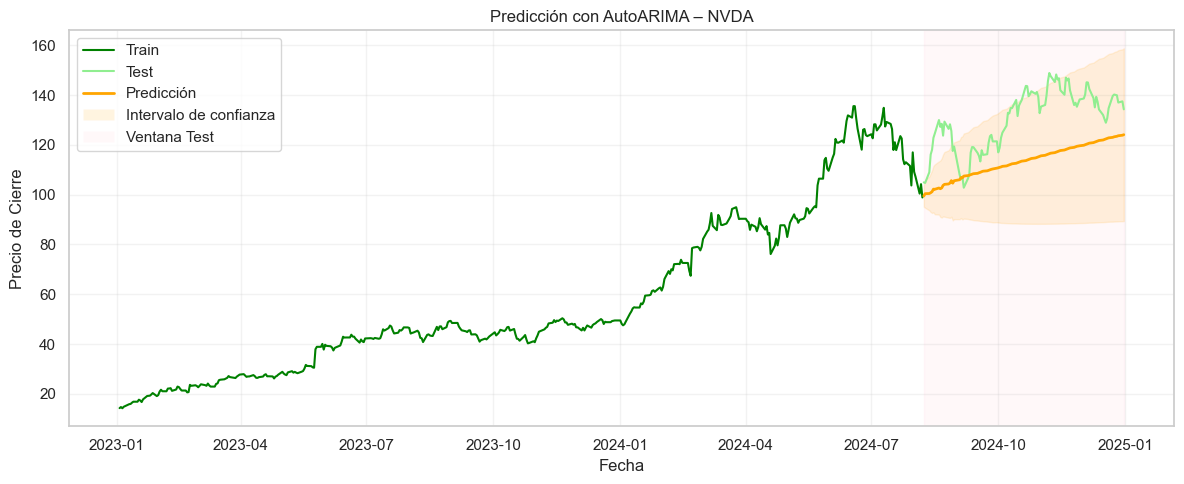

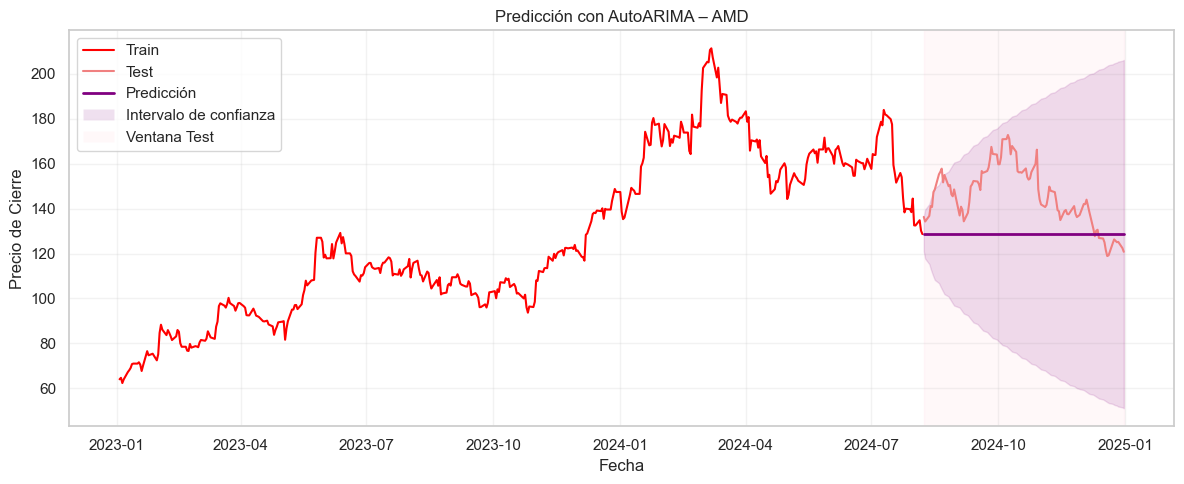

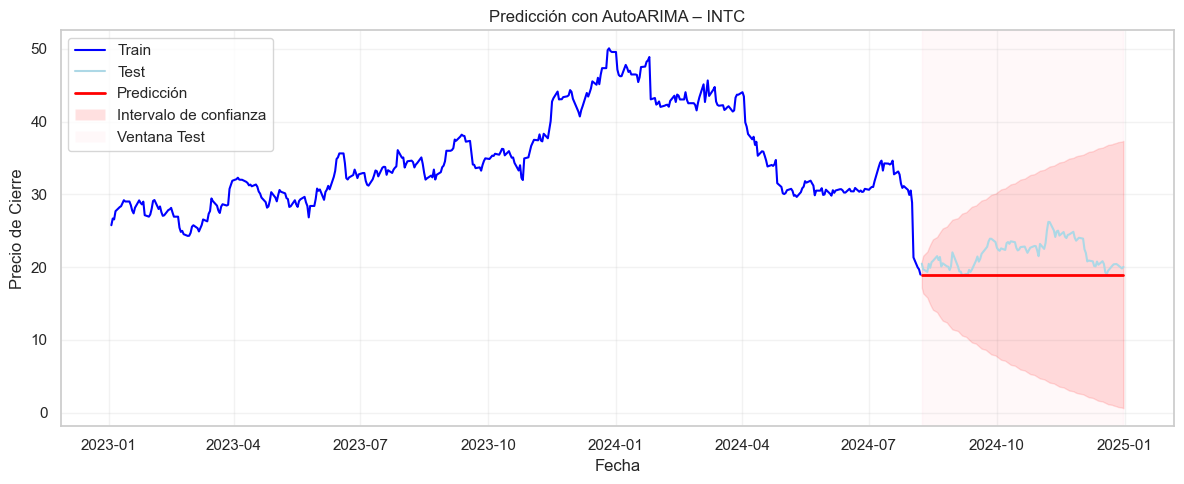

In [13]:
plot_forecast(nvda_train,  nvda_test,  models['NVDA'],
              title="Predicción con AutoARIMA – NVDA",
              c_train="green", c_test="lightgreen", c_pred="orange")
              

plot_forecast(amd_train,   amd_test,   models['AMD'],
              title="Predicción con AutoARIMA – AMD",
              c_train="red", c_test="lightcoral", c_pred="purple")

plot_forecast(intel_train, intel_test, models['INTC'],
              title="Predicción con AutoARIMA – INTC",
              c_train="blue", c_test="lightblue", c_pred="red")

### Resultados de las predicciones con AutoARIMA

#### **NVDA (NVIDIA)**
- **Train (rojo oscuro):** datos utilizados para el ajuste del modelo.  
- **Test (rojo claro):** datos reservados para validación.  
- **Predicción (línea naranja):** proyección del modelo sobre el período de test.  
- **Intervalo de confianza (área naranja claro):** rango esperado de la serie con un 95% de confianza.  
- **Ventana Test (sombreado rosado):** zona temporal correspondiente al test.  

El modelo proyecta una **tendencia suavizada y ligeramente creciente**, aunque no logra capturar los **picos de volatilidad** evidenciados en los datos de test.  


#### **AMD**
- **Predicción (línea rosa):** prácticamente plana, correspondiente a un modelo **ARIMA(0,1,0)** (paseo aleatorio).  
- **Intervalo de confianza (abanico rosa):** se expande en el horizonte, mostrando la **incertidumbre acumulada**.  

El modelo interpreta que no existen patrones claros y asume que el mejor pronóstico es **mantener el último valor conocido**.  


#### **INTC (Intel)**
- **Predicción (línea roja):** comportamiento plano, similar al de AMD.  
- **Intervalo de confianza (abanico rojo):** amplio, lo que refleja **incertidumbre elevada**.  

El modelo se comporta como un **paseo aleatorio** con bandas crecientes de incertidumbre, lo que indica **baja capacidad predictiva**.  

- **NVDA:** presenta un modelo con cierta estructura identificada, aunque suaviza en exceso y no captura la volatilidad real.  
- **AMD e INTC:** los modelos ajustados se reducen prácticamente a un **paseo aleatorio**, sin patrones relevantes.  

Estos resultados sugieren:  
- Evaluar la **estacionalidad (`m`)** utilizada.  
- Probar enfoques multivariantes (**VAR**) que consideren las tres series en conjunto.  
- Transformar las series a **rendimientos** en lugar de precios para mejorar la estacionariedad y el ajuste.  


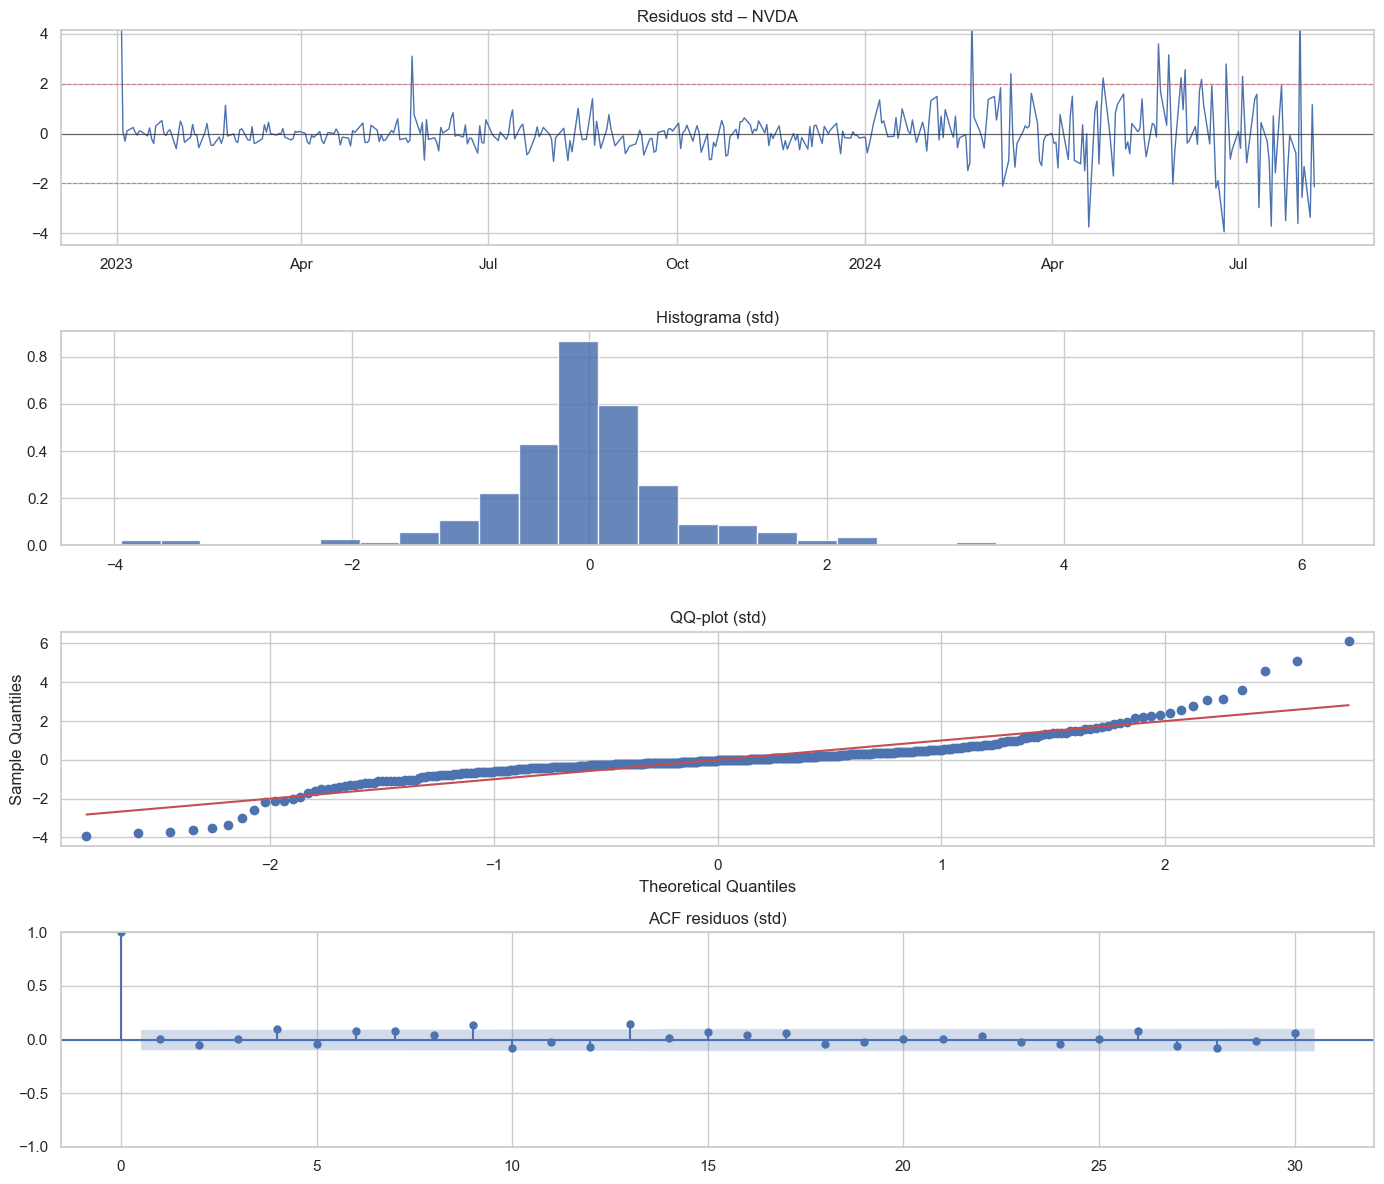

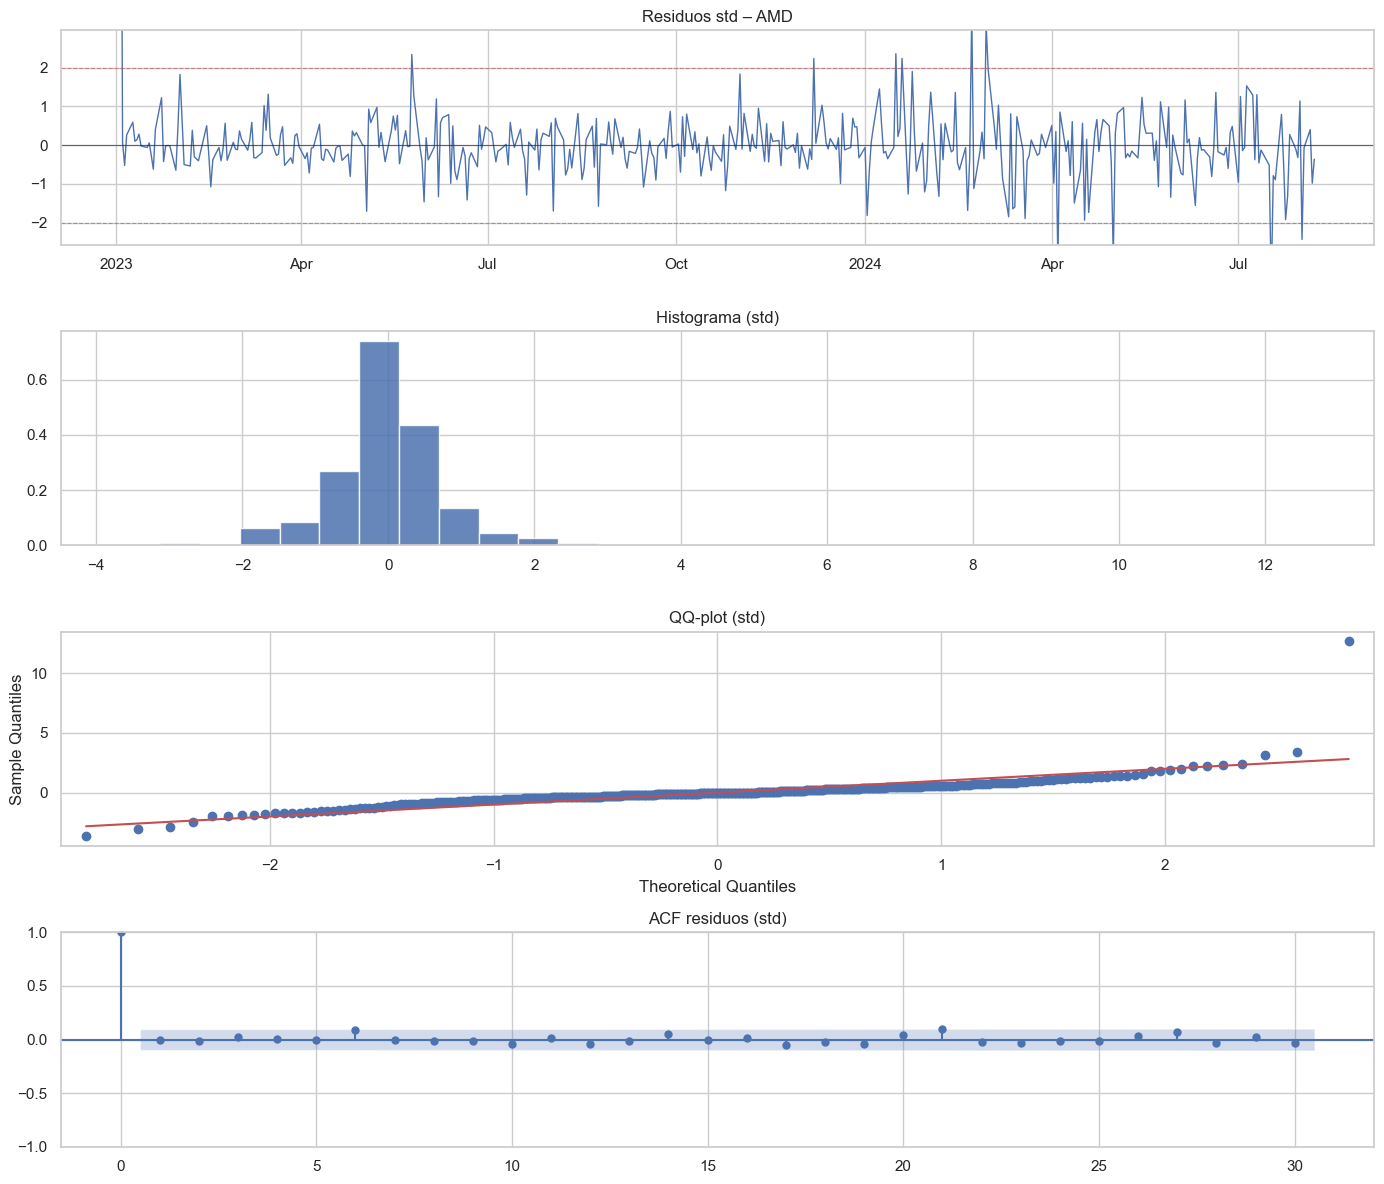

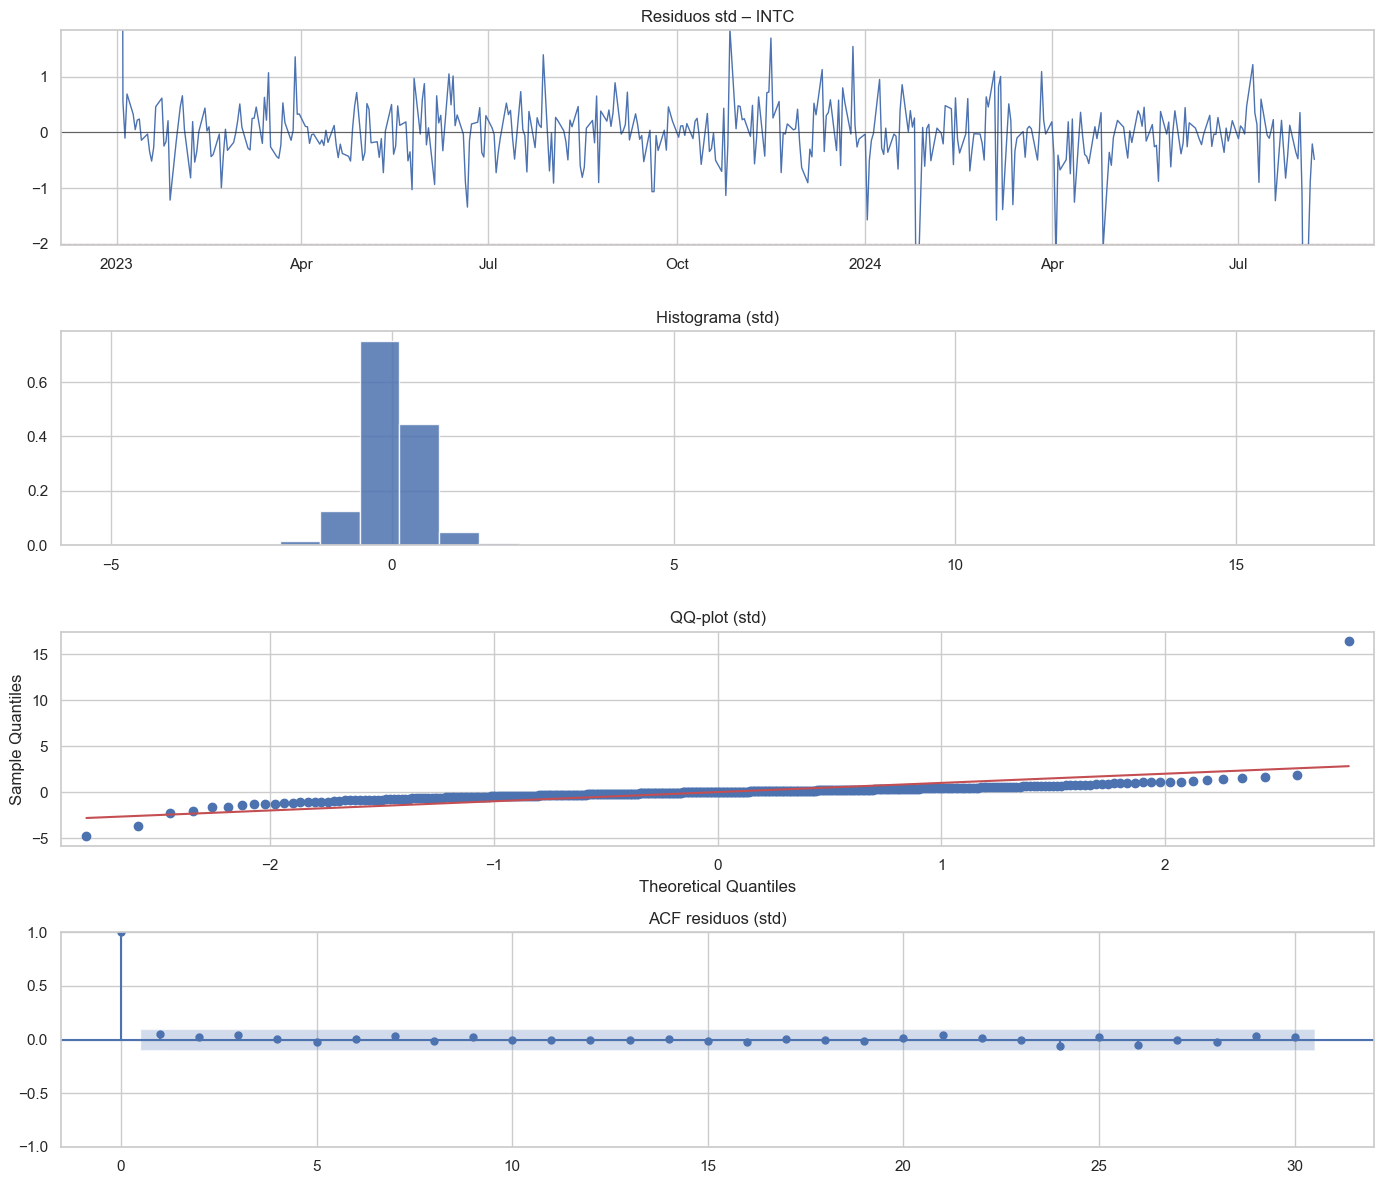


=== Diagnóstico resumido (ARIMA por serie) ===
  Ticker ARIMA(p,d,q) SARIMA(P,D,Q,m) Independencia  Normalidad  \
0   NVDA    (0, 1, 1)   (1, 0, 0, 21)    ❌ Problema  ❌ Problema   
1    AMD    (0, 1, 0)   (0, 0, 0, 21)          ✅ OK  ❌ Problema   
2   INTC    (0, 1, 0)   (0, 0, 0, 21)          ✅ OK  ❌ Problema   

  Heteroced. (ARCH) LB_p (últ. lag) Normalidad_p    ARCH_p  
0        ❌ Problema          0.0109    9.44e-256  3.54e-10  
1        ❌ Problema          0.9111     0.00e+00  2.96e-02  
2              ✅ OK          1.0000     0.00e+00  9.94e-01  


In [14]:
ALPHA = 0.05

def _get_residuals(model):
    ar = model.arima_res_
    return ar.resid() if callable(getattr(ar, "resid", None)) else ar.resid


def arima_full_diagnostics(name, model, y_train, max_acf_lag=30, arch_lags=10, verbose=False):
  
    res = np.asarray(_get_residuals(model))
    y_train = y_train.copy()
    y_train.index = pd.to_datetime(y_train.index); y_train.sort_index(inplace=True)
    idx = y_train.index[-len(res):]
    res = pd.Series(res, index=idx)
    res_std = (res - res.mean()) / res.std(ddof=1)

  
    n = len(res_std)
    max_lag = max(1, min(max_acf_lag, n - 2))
    lags_lb = [l for l in [5,10,15,20,25,30] if l <= max_lag] or [min(5, max_lag)]
    arch_lags = min(arch_lags, max(1, n // 5))

    fig, axes = plt.subplots(4, 1, figsize=(14, 12))

    axes[0].plot(res_std.index, res_std.values, lw=1)
    axes[0].axhline(0, color='k', lw=0.8, alpha=0.6)
    axes[0].axhline( 2, color='r', lw=0.8, ls='--', alpha=0.6)
    axes[0].axhline(-2, color='r', lw=0.8, ls='--', alpha=0.6)
    axes[0].set_title(f"Residuos std – {name}")

    lo, hi = np.percentile(res_std, [1, 99]); mrg = 0.15*(hi - lo) if hi > lo else 1.0
    axes[0].set_ylim(lo - mrg, hi + mrg)

    locator   = mdates.AutoDateLocator(minticks=6, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    axes[0].xaxis.set_major_locator(locator)
    axes[0].xaxis.set_major_formatter(formatter)
    for label in axes[0].get_xticklabels(): label.set_rotation(0)

    axes[1].hist(res_std, bins=30, density=True, alpha=0.85)
    axes[1].set_title("Histograma (std)")
    axes[1].yaxis.set_major_locator(MaxNLocator(nbins=5))

    sm.qqplot(res_std, line='s', ax=axes[2])
    axes[2].set_title("QQ-plot (std)")

    plot_acf(res_std, lags=max_lag, ax=axes[3])
    axes[3].set_title("ACF residuos (std)")
    plt.tight_layout(); plt.show()

    lb = acorr_ljungbox(res_std, lags=lags_lb, return_df=True).rename(
        columns={"lb_stat":"LB_stat","lb_pvalue":"LB_pvalue"})
    jb_stat, jb_p, _, _ = jarque_bera(res_std)
    ad_stat, ad_p       = normal_ad(res_std)
    arch_stat, arch_p, arch_f, arch_fp = het_arch(res_std, nlags=arch_lags)

    if verbose:
        print(f"\n Diagnóstico residuos ARIMA – {name}")
        print("Orden ARIMA (p,d,q):", model.order,
              "| Orden estacional (P,D,Q,m):", getattr(model, "seasonal_order_", getattr(model, "seasonal_order", None)))
        print("\n• Ljung–Box por lags:"); print(lb)

    return {
        "name": name,
        "order": model.order,
        "seasonal_order": getattr(model, "seasonal_order_", getattr(model, "seasonal_order", None)),
        "lb": lb, "jb_p": float(jb_p), "ad_p": float(ad_p), "arch_p": float(arch_p)
    }

diag_results = []
for ticker, mdl in models.items():
    out = arima_full_diagnostics(ticker, mdl, train_series[ticker], verbose=False)
    diag_results.append([
        ticker, out["order"], out["seasonal_order"],
        out["lb"]["LB_pvalue"].iloc[-1], out["jb_p"], out["ad_p"], out["arch_p"]
    ])

diag_table = pd.DataFrame(
    diag_results,
    columns=["Ticker", "ARIMA(p,d,q)", "SARIMA(P,D,Q,m)",
             "LB_p (últ. lag)", "JB_p", "AD_p", "ARCH_p"]
)

def _flag(p): return "✅ OK" if p >= ALPHA else "❌ Problema"
diag_table["Normalidad_p"] = diag_table[["JB_p","AD_p"]].max(axis=1)   
diag_table["Independencia"] = diag_table["LB_p (últ. lag)"].map(_flag) 
diag_table["Normalidad"]    = diag_table["Normalidad_p"].map(_flag)    
diag_table["Heteroced. (ARCH)"] = diag_table["ARCH_p"].map(_flag)

show_cols = ["Ticker","ARIMA(p,d,q)","SARIMA(P,D,Q,m)",
             "Independencia","Normalidad","Heteroced. (ARCH)",
             "LB_p (últ. lag)","Normalidad_p","ARCH_p"]
tbl = diag_table[show_cols].copy()
tbl["LB_p (últ. lag)"] = tbl["LB_p (últ. lag)"].map(lambda x: f"{x:0.4f}")
tbl["Normalidad_p"]    = tbl["Normalidad_p"].map(lambda x: f"{x:0.2e}")
tbl["ARCH_p"]          = tbl["ARCH_p"].map(lambda x: f"{x:0.2e}")

def _style_flags(s):
    return ['background-color: #e8f5e9' if 'OK' in v else 'background-color: #ffebee' for v in s]

print("\n=== Diagnóstico resumido (ARIMA por serie) ===")
try:
    display(
        tbl.style
           .apply(_style_flags, subset=["Independencia"])
           .apply(_style_flags, subset=["Normalidad"])
           .apply(_style_flags, subset=["Heteroced. (ARCH)"])
    )
except Exception:
    print(tbl)


### Diagnóstico integral de modelos ARIMA

Una vez estimados los modelos ARIMA para cada serie, es necesario validar que los 
**residuos cumplan los supuestos básicos** de independencia, homocedasticidad y normalidad.  
Este diagnóstico asegura que el modelo capture adecuadamente la dinámica temporal y que 
los pronósticos sean confiables.

El procedimiento implementado incluye:

 **Visualización de residuos estandarizados**  
   Se grafican en una escala vertical, con bandas de control (±2σ) y un eje de fechas legible, 
   para detectar outliers, cambios de varianza o patrones no explicados.

 **Histograma y QQ-plot**  
   Permiten evaluar la aproximación a la normalidad. Una distribución centrada en cero y 
   colas moderadas es deseable para inferencias válidas.

 **Función de autocorrelación (ACF) de residuos**  
   Sirve para verificar que no exista estructura temporal remanente. Los coeficientes deberían 
   estar dentro de las bandas de confianza.

 **Pruebas estadísticas formales**  
   - **Ljung–Box**: chequea autocorrelación global en los residuos.  
   - **Jarque–Bera / Anderson–Darling**: contrastan la hipótesis de normalidad.  
   - **ARCH-LM**: detecta presencia de heterocedasticidad condicional.  

 **Tabla comparativa con semáforos**  
   Resume el cumplimiento de supuestos por serie, con indicadores claros 
   (✅ OK / ❌ Problema) y los p-values correspondientes.

Este diagnóstico integral permite comparar los tres modelos (NVDA, AMD e INTC) y decidir 
si es necesario ajustar órdenes alternativos, aplicar transformaciones adicionales o 
considerar extensiones como GARCH en caso de heterocedasticidad persistente.



Diagnóstico de residuos de los modelos ARIMA

A continuación se presentan los resultados del diagnóstico integral aplicado a cada 
modelo ARIMA estimado (NVDA, AMD e INTC). Se incluyen tanto las visualizaciones 
de residuos como la tabla comparativa de supuestos.

 NVDA – ARIMA(0,1,1)(1,0,0)[21]
- **Residuos estandarizados**: se observa cierta volatilidad creciente hacia 2024, con 
  valores que exceden las bandas ±2σ, lo que sugiere episodios de heterocedasticidad.  
- **Histograma y QQ-plot**: evidencian asimetría y colas pesadas, alejándose de la normalidad.  
- **ACF de residuos**: aunque la mayoría de autocorrelaciones caen dentro de las bandas, 
  los tests rechazan independencia en rezagos altos.  
- **Conclusión**: el modelo captura la dinámica principal, pero deja autocorrelación 
  remanente, no cumple normalidad y presenta heterocedasticidad (ARCH).

 AMD – ARIMA(0,1,0)(0,0,0)[21]
- **Residuos estandarizados**: centrados en torno a cero, aunque con algunos outliers 
  relevantes.  
- **Histograma y QQ-plot**: muestran colas largas, lo que indica desviaciones de la normalidad.  
- **ACF de residuos**: no se detecta autocorrelación significativa, confirmando independencia.  
- **Conclusión**: el modelo logra independencia de residuos, pero no cumple normalidad 
  y presenta heterocedasticidad (ARCH), típico en series financieras.

 INTC – ARIMA(0,1,0)(0,0,0)[21]
- **Residuos estandarizados**: se mantienen estables, sin grandes desviaciones ni tendencia.  
- **Histograma y QQ-plot**: colas pesadas y alejamientos de la normalidad, como en los 
  casos anteriores.  
- **ACF de residuos**: las autocorrelaciones se encuentran dentro de las bandas, sin 
  evidencia de dependencia.  
- **Conclusión**: el modelo cumple independencia de residuos y no presenta heterocedasticidad 
  significativa, aunque no satisface la normalidad.


 Tabla comparativa de supuestos

| Ticker | ARIMA(p,d,q) | SARIMA(P,D,Q,m) | Independencia | Normalidad | Heteroced. (ARCH) | LB_p (últ. lag) | Normalidad_p | ARCH_p |
|--------|--------------|-----------------|---------------|------------|-------------------|-----------------|--------------|--------|
| NVDA   | (0,1,1)      | (1,0,0,21)      | ❌ Problema    | ❌ Problema | ❌ Problema        | 0.0109          | 9.43e-256    | 3.54e-10 |
| AMD    | (0,1,0)      | (0,0,0,21)      | ✅ OK          | ❌ Problema | ❌ Problema        | 0.9111          | 0.00e+00     | 2.96e-02 |
| INTC   | (0,1,0)      | (0,0,0,21)      | ✅ OK          | ❌ Problema | ✅ OK              | 1.0000          | 0.00e+00     | 9.94e-01 |

---


- **Independencia**: AMD e INTC cumplen el supuesto de residuos no autocorrelacionados; NVDA presenta problemas.  
- **Normalidad**: los tres modelos fallan este supuesto (esperable en precios bursátiles).  
- **Heterocedasticidad**: NVDA y AMD muestran evidencia de ARCH, mientras que INTC no.  

Esto implica que, si bien los modelos son útiles para pronóstico de medias, su capacidad 
para generar intervalos de confianza precisos está limitada. En contextos financieros, 
sería recomendable considerar modelos que manejen varianza condicional, como **GARCH**.


### Métricas de performance

Con el objetivo de evaluar la capacidad predictiva de los modelos ajustados, se calculan
las siguientes métricas sobre el **conjunto de Testing**:

- **MSE (Mean Squared Error):** promedio de los errores al cuadrado.  
- **RMSE (Root Mean Squared Error):** raíz del MSE, en las mismas unidades del precio.  
- **MAE (Mean Absolute Error):** error absoluto promedio, más robusto frente a valores extremos.  
- **MAPE (Mean Absolute Percentage Error):** error porcentual promedio respecto a los valores reales,
  útil para comparar entre series de distinta magnitud.

Estas métricas permiten analizar tanto la magnitud absoluta de los errores (MSE, RMSE, MAE)
como su relevancia relativa (MAPE).

In [15]:
fc_nvda_arr, _ = models["NVDA"].predict(n_periods=len(nvda_test),  return_conf_int=True)
fc_amd_arr,  _ = models["AMD"].predict(n_periods=len(amd_test),    return_conf_int=True)
fc_intc_arr, _ = models["INTC"].predict(n_periods=len(intel_test), return_conf_int=True)

fc_nvda = pd.Series(fc_nvda_arr, index=nvda_test.index,  name="fc_nvda")
fc_amd  = pd.Series(fc_amd_arr,  index=amd_test.index,   name="fc_amd")
fc_intc = pd.Series(fc_intc_arr, index=intel_test.index, name="fc_intc")


def _align_clean(y_true, y_pred):
    """
    Interseca fechas de y y yhat, convierte a float64, elimina NaN/Inf.
    Devuelve dos Series (y, yhat) perfectamente alineadas.
    """
    y    = pd.Series(y_true, dtype="float64", name="y")
    yhat = pd.Series(y_pred, dtype="float64", name="yhat")
    df = pd.concat([y, yhat], axis=1, join="inner").replace([np.inf, -np.inf], np.nan).dropna()
    if df.empty:
        raise ValueError("Tras alinear y limpiar, no quedan observaciones válidas.")
    return df["y"], df["yhat"]

def mape(y_true, y_pred, eps=1e-8):
    y, yhat = _align_clean(y_true, y_pred)
    mask = np.abs(y.values) > eps
    if not mask.any():
        return np.nan
    return float(np.mean(np.abs((y.values[mask] - yhat.values[mask]) / y.values[mask])) * 100)

def compute_metrics(y_true, y_pred):
    y, yhat = _align_clean(y_true, y_pred)
    mse  = mean_squared_error(y, yhat)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y, yhat)
    return {"MSE": float(mse), "RMSE": float(rmse), "MAE": float(mae), "MAPE": float(mape(y, yhat))}

res = {
    "NVDA": compute_metrics(nvda_test,  fc_nvda),
    "AMD":  compute_metrics(amd_test,   fc_amd),
    "INTC": compute_metrics(intel_test, fc_intc),
}

metricas_arima = (
    pd.DataFrame(res)
      .T.loc[["NVDA","AMD","INTC"]]
      .round({"MSE":6, "RMSE":6, "MAE":6, "MAPE":2})
)

print("\nMétricas de performance en TEST (MSE / RMSE / MAE / MAPE %)")
print(metricas_arima)


Métricas de performance en TEST (MSE / RMSE / MAE / MAPE %)
             MSE       RMSE        MAE   MAPE
NVDA  369.484877  19.221989  17.324497  12.89
AMD   480.355562  21.917015  18.827962  12.30
INTC   12.143846   3.484802   2.965306  12.91


- En términos absolutos (**MSE, RMSE, MAE**), los mayores errores corresponden a **AMD** y **NVDA**, lo cual es coherente con su mayor nivel de precios y volatilidad.  
- **INTC** muestra errores absolutos mucho menores, en línea con su escala de precios más baja.  
- Sin embargo, al considerar el **MAPE**, los tres activos presentan un desempeño muy similar, en torno al **12–13%**, lo que indica una **precisión relativa homogénea** entre las series.  

En conjunto, el modelo logra capturar la dinámica de los tres activos con un nivel de error porcentual estable, aun cuando las magnitudes absolutas de los errores varían según la escala de cada serie.



## <span id="var"></span> VAR  

Para estimar un modelo de **Vectores Autorregresivos (VAR)** entre **NVIDIA (NVDA)**, **AMD** e **Intel (INTC)**, se transformaron los precios de cierre en **rendimientos logarítmicos diarios**. Esta transformación garantiza la **estacionariedad en media y varianza** (condición indispensable para la validez del VAR) y permite **comparar activos en una escala homogénea**.  

Una vez construidas las series de retornos, se seleccionó el orden de rezago \(p\) utilizando criterios de información (AIC, BIC, HQIC). Posteriormente, se evaluó la **estabilidad del sistema**, verificando que todas las raíces características se encontrasen fuera del círculo unitario (es decir, que el valor absoluto mínimo de las raíces fuera mayor que 1). Finalmente, se realizaron pruebas de diagnóstico de residuos para confirmar la **ausencia de autocorrelación**, la **no presencia de heterocedasticidad condicional** y la **evaluación de la normalidad de las innovaciones**.  

Además del ajuste del modelo, se desarrollaron los análisis de **funciones Impulso-Respuesta (IRF)** y de **causalidad de Granger**, con el fin de explorar la transmisión dinámica de shocks y la dirección de las relaciones entre los activos.  


OK: logret listo → (520, 3) | ['NVDA_ret', 'AMD_ret', 'INTC_ret']


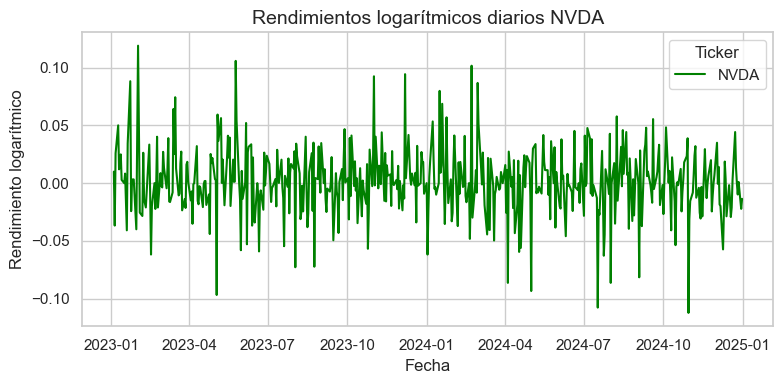

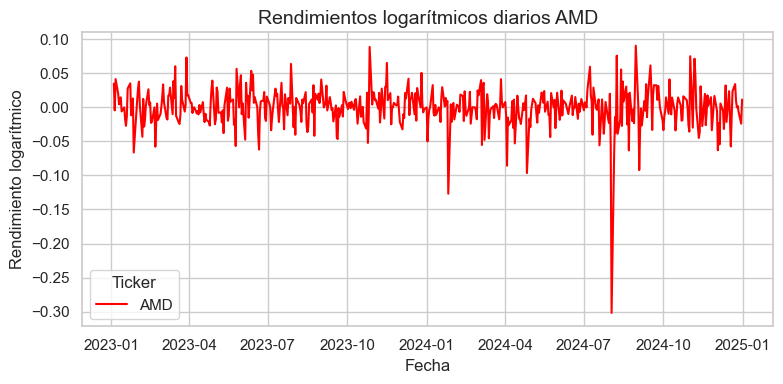

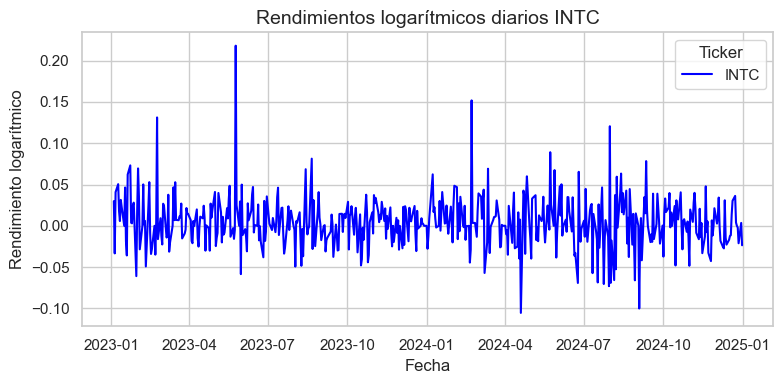


=== Estadísticos descriptivos de los rendimientos logarítmicos (2023–2025) ===
              mean       std       min       25%       50%       75%  \
NVDA_ret  0.001221  0.029288 -0.112235 -0.014040  0.000000  0.018263   
AMD_ret  -0.000483  0.028986 -0.301896 -0.015568  0.000557  0.015114   
INTC_ret  0.004307  0.030600 -0.105412 -0.013640  0.002986  0.021648   

               max      skew   kurtosis  
NVDA_ret  0.118921  0.001483   2.134258  
AMD_ret   0.090648 -2.323082  23.046819  
INTC_ret  0.218088  0.907342   6.165988  


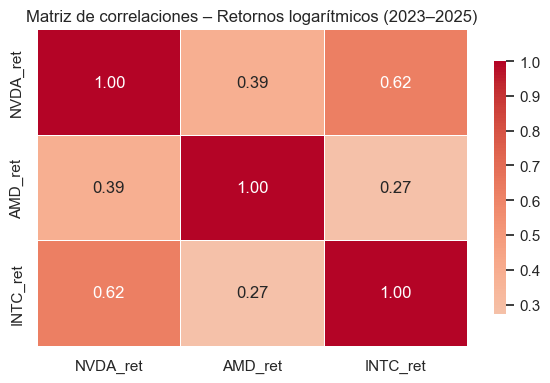

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -21.74*     -21.71*  3.620e-10*     -21.73*
1       -21.74      -21.64   3.627e-10      -21.70
2       -21.72      -21.55   3.684e-10      -21.65
3       -21.70      -21.45   3.750e-10      -21.61
4       -21.68      -21.36   3.829e-10      -21.56
5       -21.66      -21.26   3.916e-10      -21.50
6       -21.65      -21.17   3.959e-10      -21.46
7       -21.64      -21.08   4.016e-10      -21.42
8       -21.61      -20.98   4.131e-10      -21.36
9       -21.60      -20.89   4.180e-10      -21.32
10      -21.58      -20.80   4.249e-10      -21.27
11      -21.56      -20.71   4.332e-10      -21.23
12      -21.56      -20.63   4.351e-10      -21.19
13      -21.57      -20.56   4.307e-10      -21.17
14      -21.55      -20.47   4.399e-10      -21.12
15      -21.52      -20.37   4.498e-10      -21.07
-------------------------------

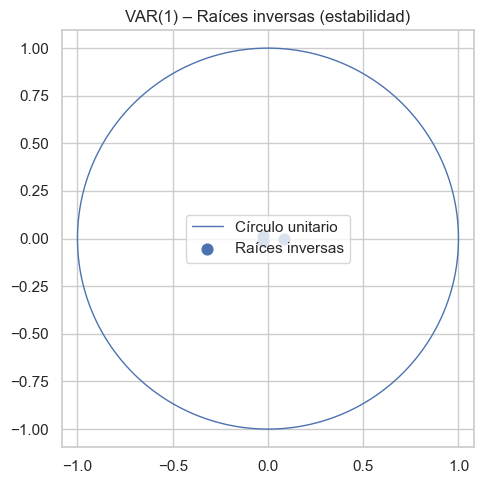


Diagnóstico de residuos: NVDA_ret
Ljung-Box (lags=10,20):
      lb_stat  lb_pvalue
10  11.881082   0.293094
20  22.063546   0.337072
Jarque-Bera: (96.2019316228372, 1.2882969359637679e-21, -0.0031334031731040223, 5.109171629818784)
Anderson-Darling Normal: (3.7266955307989065, 2.636391639728481e-09)
ARCH(10): (4.652728933980739, 0.9131372623482912, 0.4594173780746238, 0.9156787925427954)

Diagnóstico de residuos: AMD_ret
Ljung-Box (lags=10,20):
      lb_stat  lb_pvalue
10   2.880794   0.984092
20  12.001485   0.916025
Jarque-Bera: (10695.885162591494, 0.0, -2.23296755281072, 24.78675813412795)
Anderson-Darling Normal: (6.745371544736372, 1.5197212453077446e-16)
ARCH(10): (2.2349132674224133, 0.9942020005044871, 0.2196257864472191, 0.9944728923286426)

Diagnóstico de residuos: INTC_ret
Ljung-Box (lags=10,20):
      lb_stat  lb_pvalue
10   8.256137   0.603833
20  20.979644   0.398332
Jarque-Bera: (905.3427211576034, 2.554618100423869e-197, 0.9377552767094298, 9.192577776976536)
Anderson

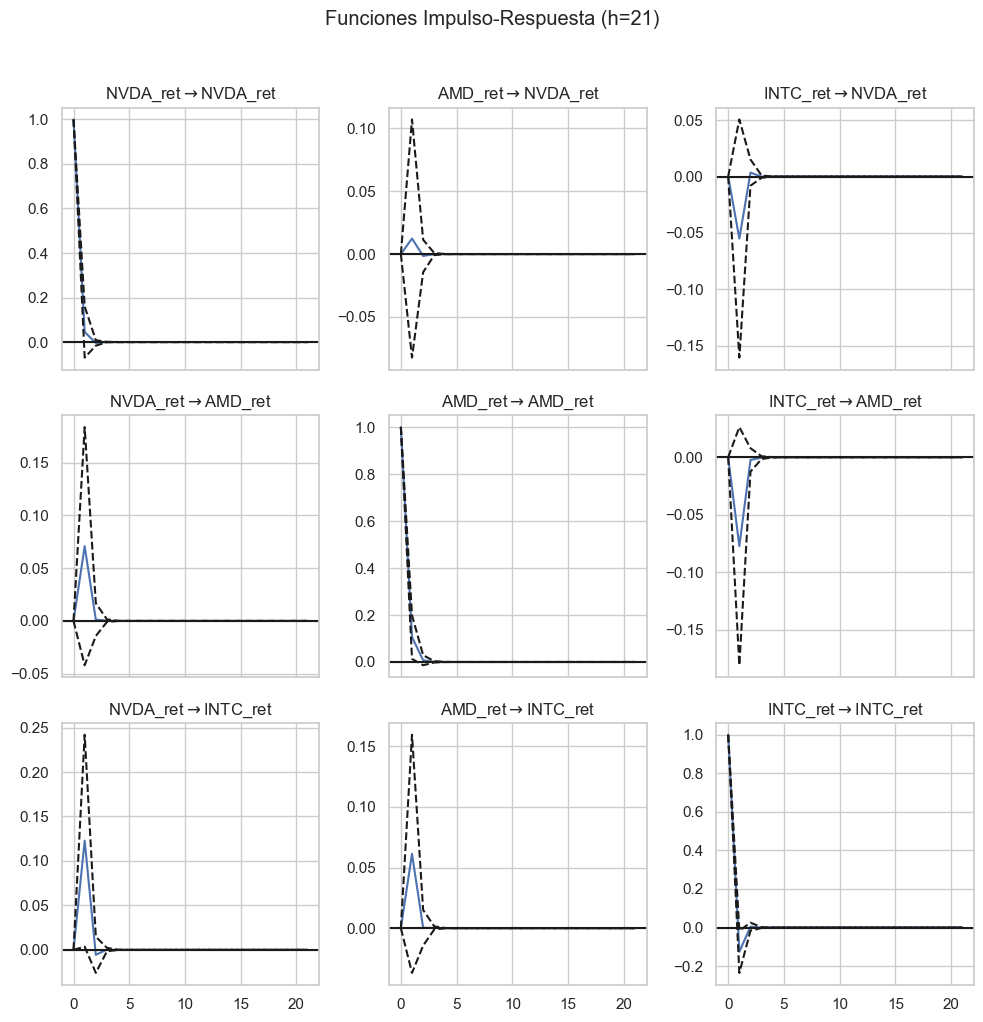

/Users/paul/Downloads/Documentos Locales/AST_MCD_E10/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/paul/Downloads/Documentos Locales/AST_MCD_E10/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/paul/Downloads/Documentos Locales/AST_MCD_E10/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/paul/Downloads/Documentos Locales/AST_MCD_E10/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/paul/Downloads/Documentos Locales/AST_MCD_E10/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: Futur


Tabla Granger (p-valor mínimo por dirección):
  Dependiente (y) Exógena (x)  p-valor (mín)
3        INTC_ret    NVDA_ret       0.013567
5        INTC_ret     AMD_ret       0.060375
2        NVDA_ret    INTC_ret       0.312673
4         AMD_ret    INTC_ret       0.357887
1         AMD_ret    NVDA_ret       0.640760
0        NVDA_ret     AMD_ret       0.833905


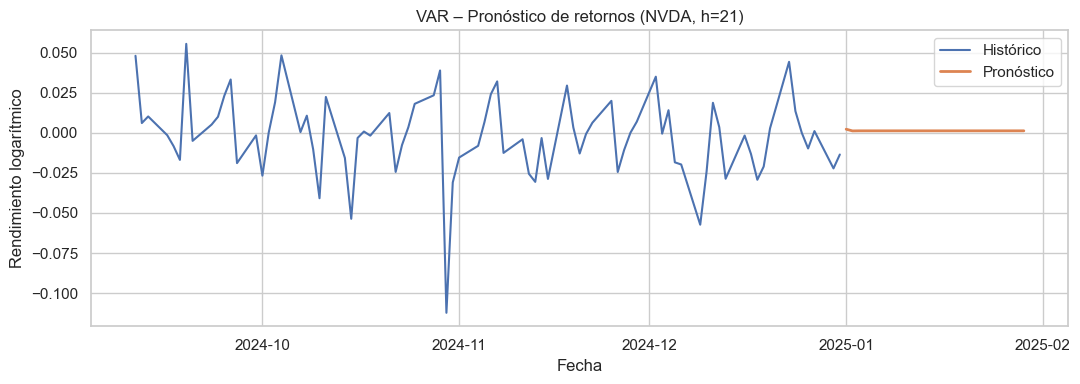

In [16]:
close_b = close.asfreq("B").ffill().sort_index()

logret = np.log(close_b).diff().dropna()
logret.columns = ["NVDA_ret", "AMD_ret", "INTC_ret"]

assert logret.notna().all().all(), "Hay NaN/Inf en logret"
print("OK: logret listo →", logret.shape, "|", list(logret.columns))

plt.figure(figsize=(8,4))
plt.plot(logret.index, logret["NVDA_ret"], color="green",  label="NVDA")
plt.title("Rendimientos logarítmicos diarios NVDA", fontsize=14)
plt.xlabel("Fecha"); plt.ylabel("Rendimiento logarítmico")
plt.legend(title="Ticker"); plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(logret.index, logret["AMD_ret"],  color="red",    label="AMD")
plt.title("Rendimientos logarítmicos diarios AMD", fontsize=14)
plt.xlabel("Fecha"); plt.ylabel("Rendimiento logarítmico")
plt.legend(title="Ticker"); plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(logret.index, logret["INTC_ret"], color="blue",   label="INTC")
plt.title("Rendimientos logarítmicos diarios INTC", fontsize=14)
plt.xlabel("Fecha"); plt.ylabel("Rendimiento logarítmico")
plt.legend(title="Ticker"); plt.grid(True)
plt.tight_layout()
plt.show()

desc_logret = logret.describe().T[["mean","std","min","25%","50%","75%","max"]]
desc_logret["skew"] = logret.skew()
desc_logret["kurtosis"] = logret.kurtosis()
print("\n=== Estadísticos descriptivos de los rendimientos logarítmicos (2023–2025) ===")
print(desc_logret.round(6))

corr = logret.corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, linecolor="white", cbar_kws={"shrink": 0.8})
plt.title("Matriz de correlaciones – Retornos logarítmicos (2023–2025)")
plt.tight_layout()
plt.show()

def select_p_ic(sel_obj):
    for k in ("aic", "hqic", "bic"):
        v = getattr(sel_obj, k, None)
        if v is not None:
            return int(v)
    return 1

sel = VAR(logret).select_order(maxlags=15)
print(sel.summary())
p0 = select_p_ic(sel)
print(f"[IC] p inicial sugerido: {p0}")

def try_fit_VAR(data, p, trend="c"):
    mod = VAR(data).fit(p, trend=trend)
    roots = np.abs(mod.roots) if p >= 1 else np.array([])
    stable = (p == 0) or (roots.min() > 1.0)
    return mod, roots, stable

p_candidates = list(range(max(1, p0), 0, -1))
best = None

for p in p_candidates:
    try:
        mod, roots, stable = try_fit_VAR(logret, p, trend="c")
        print(f"Intento VAR({p}) trend='c' | min|root|: {roots.min() if p>=1 else 'N/A'} | estable: {stable}")
        if stable:
            best = ("c", p, mod, roots)
            break
    except Exception as e:
        print(f"VAR({p}) trend='c' falló: {e}")

if best is None:
    for p in p_candidates:
        try:
            mod, roots, stable = try_fit_VAR(logret, p, trend="n")
            print(f"Intento VAR({p}) trend='n' | min|root|: {roots.min() if p>=1 else 'N/A'} | estable: {stable}")
            if stable:
                best = ("n", p, mod, roots)
                break
        except Exception as e:
            print(f"VAR({p}) trend='n' falló: {e}")

if best is None:
    z = (logret - logret.mean()) / logret.std(ddof=1)
    z = z.replace([np.inf, -np.inf], np.nan).dropna()
    print("[Aviso] Estandarizando retornos (z-score) y reintentando...")
    sel_z = VAR(z).select_order(maxlags=15)
    p0_z = select_p_ic(sel_z)
    p_candidates_z = list(range(max(1, p0_z), 0, -1))
    for trend in ("c", "n"):
        for p in p_candidates_z:
            try:
                mod, roots, stable = try_fit_VAR(z, p, trend=trend)
                print(f"Intento VAR({p}) trend='{trend}' (z) | min|root|: {roots.min() if p>=1 else 'N/A'} | estable: {stable}")
                if stable:
                    best = (trend, p, mod, roots, "z")
                    break
            except Exception as e:
                print(f"VAR({p}) trend='{trend}' (z) falló: {e}")
        if best is not None:
            break

if best is None:
    print("[AVISO] No se logró un VAR estable con p>=1. Se ajusta VAR(0) (sin dinámica).")
    mod, roots, stable = try_fit_VAR(logret, 0, trend="c")
    best = ("c", 0, mod, np.array([]))

if len(best) == 4:
    trend_sel, p_sel, var_mod, roots = best
    data_used = "logret (original)"
else:
    trend_sel, p_sel, var_mod, roots, flag = best
    data_used = "z-score(logret)" if flag == "z" else "logret (original)"

print(f"\n[Resultado] VAR({p_sel}) trend='{trend_sel}' | estable: {('sí' if (p_sel==0 or roots.min() > 1.0) else 'no')}")
print(f"Datos usados: {data_used}")
print(var_mod.summary())
if p_sel >= 1:
    print(f"Mín |root|: {roots.min():.6f}")

if p_sel >= 1:
    theta = np.linspace(0, 2*np.pi, 600)
    plt.figure(figsize=(5,5))
    plt.plot(np.cos(theta), np.sin(theta), lw=1, label="Círculo unitario")
    inv_roots = 1 / var_mod.roots
    plt.scatter(inv_roots.real, inv_roots.imag, s=60, label="Raíces inversas")
    plt.title(f"VAR({p_sel}) – Raíces inversas (estabilidad)")
    plt.axis('equal'); plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.show()

res = var_mod.resid
for col in res.columns:
    print(f"\nDiagnóstico de residuos: {col}")
    print("Ljung-Box (lags=10,20):")
    print(acorr_ljungbox(res[col], lags=[10, 20], return_df=True))
    print("Jarque-Bera:", jarque_bera(res[col]))
    print("Anderson-Darling Normal:", normal_ad(res[col]))
    print("ARCH(10):", het_arch(res[col], nlags=10))

if p_sel >= 1:
    h = 21
    irf = var_mod.irf(h)
    fig_irf = irf.plot(orth=False)
    fig_irf.suptitle(f"Funciones Impulso-Respuesta (h={h})", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("\n[Nota] VAR(0): sin dinámica → no aplica IRF.")

pairs = [("NVDA_ret","AMD_ret"), ("AMD_ret","NVDA_ret"),
         ("NVDA_ret","INTC_ret"), ("INTC_ret","NVDA_ret"),
         ("AMD_ret","INTC_ret"), ("INTC_ret","AMD_ret")]

rows = []
for y, x in pairs:
    try:
        res_g = grangercausalitytests(logret[[y, x]], maxlag=max(1, p_sel), verbose=False)
        pmins = [res_g[L][0]["ssr_ftest"][1] for L in range(1, max(1, p_sel)+1)]
        rows.append({"Dependiente (y)": y, "Exógena (x)": x, "p-valor (mín)": float(np.min(pmins))})
    except Exception as e:
        rows.append({"Dependiente (y)": y, "Exógena (x)": x, "p-valor (mín)": np.nan})
        print(f"Granger {x}→{y} error:", e)

tab_granger = pd.DataFrame(rows).sort_values("p-valor (mín)")
print("\nTabla Granger (p-valor mínimo por dirección):")
print(tab_granger)

if p_sel >= 1:
    steps = 21
    last_y = logret.values[-p_sel:]
    fc = var_mod.forecast(y=last_y, steps=steps)
    idx_fc = pd.bdate_range(logret.index[-1] + pd.offsets.BDay(1), periods=steps)
    fc = pd.DataFrame(fc, index=idx_fc, columns=logret.columns)

    plt.figure(figsize=(11,4))
    plt.plot(logret.index[-80:], logret["NVDA_ret"].iloc[-80:], label="Histórico")
    plt.plot(fc.index, fc["NVDA_ret"], lw=2, label="Pronóstico")
    plt.title("VAR – Pronóstico de retornos (NVDA, h=21)")
    plt.xlabel("Fecha"); plt.ylabel("Rendimiento logarítmico")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()



### Resultados

### Ajuste del modelo VAR y diagnóstico

Aunque los criterios de información (AIC, BIC, HQIC) favorecían un **VAR(0)**, la búsqueda robusta permitió identificar un **VAR(1)** **estable** (mínima raíz ≈ **12.20** > 1), lo que confirma **dependencias dinámicas de primer orden** entre los retornos de **NVDA**, **AMD** e **INTC**.

**Estimaciones relevantes (VAR(1))**  
- **NVDA_ret:** los rezagos (propios y cruzados) no resultan significativos.  
- **AMD_ret:** evidencia **persistencia autorregresiva** (AMD_ret\[-1] ≈ **0.106**, *p*<0.05).  
- **INTC_ret:**  
  - efecto **positivo** desde **NVDA_ret\[-1]** (≈ **0.123**, *p*<0.05);  
  - **efecto correctivo** propio (**INTC_ret\[-1]** ≈ **−0.126**, *p*<0.05);  
  - constante positiva y significativa (sesgo alcista en el retorno promedio).

**Correlación contemporánea de residuos**  
NVDA–INTC ≈ **0.62**, NVDA–AMD ≈ **0.39**, AMD–INTC ≈ **0.26**. Esto sugiere **shocks comunes de mercado** que impactan simultáneamente a los tres activos.

**Diagnóstico de residuos**  
- **Independencia (Ljung–Box):** no se detecta autocorrelación (*p* > 0.30).  
- **Heterocedasticidad condicional (ARCH(10)):** sin evidencia relevante.  
- **Normalidad:** se **rechaza** (Jarque–Bera y Anderson–Darling), consistente con **colas pesadas**/leptocurtosis típicas de retornos financieros.

**Figura 3.** Raíces (inversas) del VAR(1) fuera del círculo unitario → **sistema estable**.


### Transmisión de shocks e interdependencias

**Funciones Impulso–Respuesta (IRF, h=21):** los shocks provocan respuestas iniciales apreciables que se **disipan rápidamente**; las respuestas cruzadas son **moderadas**, coherentes con la interdependencia del sector pero sin arrastres persistentes.

**Causalidad de Granger (maxlag = 1):**  
- **NVDA → INTC:** **significativa** (*p* ≈ **0.0136**).  
- **AMD → INTC:** **marginal** (*p* ≈ **0.0604**).  
- Resto de direcciones: no significativas.

Interpretación: **NVDA aparece como emisor de información hacia INTC**, mientras que AMD exhibe un efecto propio de persistencia, con menor capacidad de arrastre sobre las demás.

**Figura 4.** Panel IRF (h = 21).  
**Tabla 1.** Causalidad de Granger (única relación robusta: **NVDA → INTC**).


### Pronósticos

Se proyectaron **21 días hábiles** para **NVDA_ret**. Como es habitual en retornos diarios, las trayectorias son **cercanas a cero y sin tendencia**, lo que confirma la **capacidad predictiva limitada** de modelos lineales para series altamente volátiles. El **valor** del VAR en este contexto proviene sobre todo de **entender interdependencias** (IRF, Granger) más que de la predicción puntual.

**Figura 5.** Pronóstico VAR(1) de retornos de NVDA (h = 21).

**Síntesis operativa:**  
- **AMD**: persistencia de corto plazo en sus retornos.  
- **INTC**: efecto correctivo propio y **dependencia de NVDA**.  
- **NVDA**: no recibe efectos rezagados significativos, pero **transmite shocks a INTC**.  
- **Conclusión**: el VAR(1) es **estable**, capta **dinámica de primer orden** y revela una **estructura de liderazgo de NVDA** sobre INTC; útil para análisis de impacto más que para *forecasting* de retornos.


### Análisis de IRF

Las **Funciones de Respuesta al Impulso (IRF)** muestran cómo reaccionan los retornos cuando aplicamos un **shock unitario** a una de las variables en un modelo **VAR(1)**.  
Para identificar los shocks usamos la **descomposición de Cholesky**, que los vuelve ortogonales.  
**Orden de variables (importa en Cholesky):** `AMD_ret`, `INTC_ret`, `NVDA_ret`.

El horizonte de análisis es de **21 días hábiles (~1 mes)**.

El gráfico 3×3 se interpreta así:
- **Eje vertical:** magnitud de la respuesta del retorno.  
- **Eje horizontal:** tiempo (días).  
- **Diagonal:** respuesta propia (shock en la misma serie).  
- **Fuera de la diagonal:** respuestas cruzadas (shock en otra serie).  
- Las líneas punteadas representan **intervalos de confianza al 95%**.


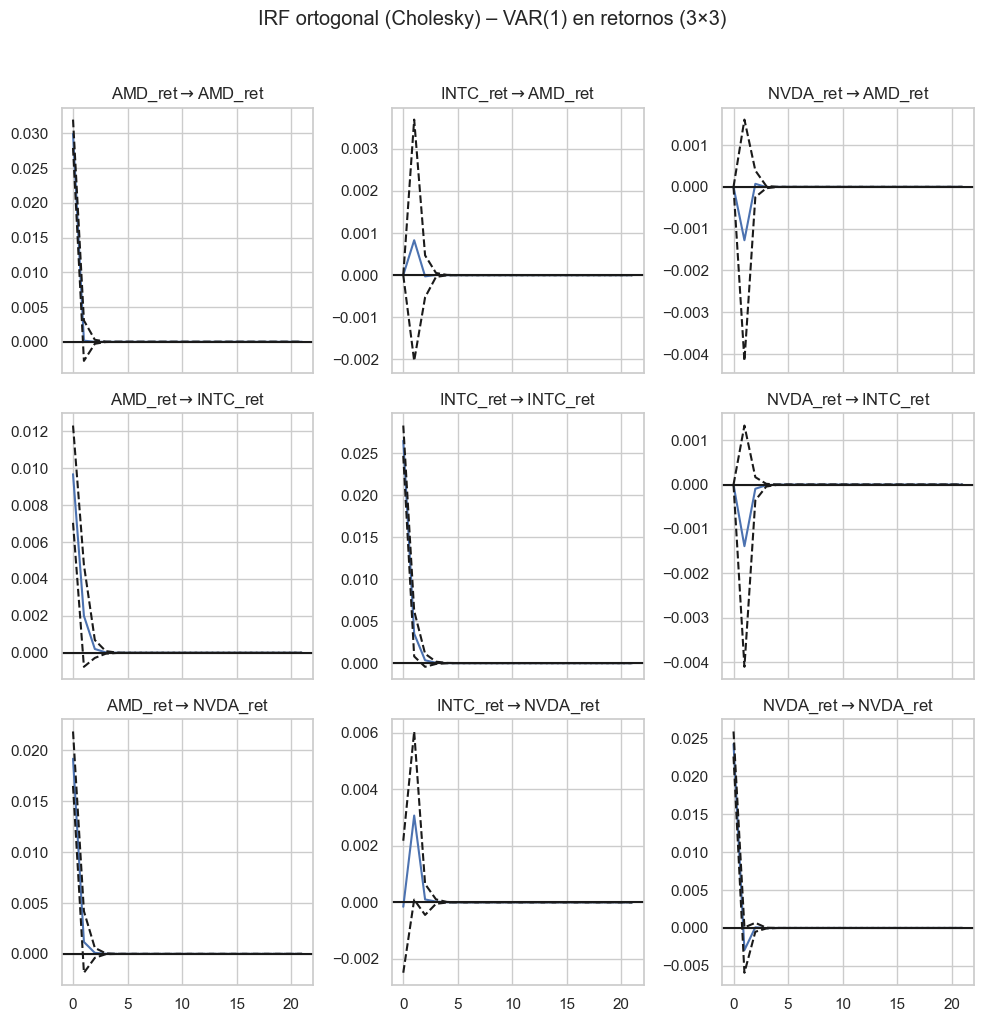

In [17]:
if 'close_b' not in globals():
    assert 'close' in globals(), "Falta 'close' (df de precios con NVDA/AMD/INTC)."
    close_b = close.asfreq("B").ffill().sort_index()

if not all(k in globals() for k in ['P_train','R_train']):
    idx_split = int(len(close_b) * 0.80)
    P_train = close_b.iloc[:idx_split].copy()
    R_train = np.log(P_train).diff().dropna()
    R_train.columns = [f"{c}_ret" for c in R_train.columns]

model3 = VAR(R_train)

mod_tmp = model3.fit(maxlags=15, ic='aic', trend='c')
p_try = max(1, int(getattr(mod_tmp, "k_ar", 0)))

mod_tr = None
for p in range(p_try, 0, -1):
    try:
        m = model3.fit(p, trend='c')
        if getattr(m, "k_ar", 0) >= 1:
            mod_tr = m
            p_tr = m.k_ar
            break
    except Exception:
        continue

def irf_plot(res, h, title):
    irf = res.irf(h)
    fig = irf.plot(orth=True)
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    plt.show()

h = 21

if mod_tr is not None and mod_tr.k_ar >= 1:
    irf_plot(mod_tr, h, f"IRF ortogonal (Cholesky) – VAR({p_tr}) en retornos (3×3)")
else:
    print("[INFO] El VAR 3×3 quedó con p=0 o no es utilizable. Se usa fallback a VAR bivariado por pares.")
    pairs = [("NVDA_ret","AMD_ret"), ("NVDA_ret","INTC_ret"), ("AMD_ret","INTC_ret")]
    for a,b in pairs:
        df = R_train[[a.replace("_ret","")]].copy()  
        if a not in R_train.columns or b not in R_train.columns:
            Rt = np.log(P_train[[a.replace("_ret",""), b.replace("_ret","")]]).diff().dropna()
            Rt.columns = [f"{c}_ret" for c in Rt.columns]
        else:
            Rt = R_train[[a, b]].copy()

        model2 = VAR(Rt)
        res2 = None
        for p in (3,2,1):
            try:
                m2 = model2.fit(p, trend='c')
                if m2.k_ar >= 1:
                    res2 = m2
                    break
            except Exception:
                continue
        if res2 is None:
            res2 = model2.fit(1, trend='c')

        title = f"IRF (Cholesky) – VAR({res2.k_ar}) {a}/{b}"
        irf_plot(res2, h, title)

Resultados del IRF ortogonal (Cholesky)

**Respuestas propias (diagonal):**
- **AMD, INTC y NVDA** muestran un **pico inicial** y luego **se disipan rápido** hacia 0 (≈**1–3 días**).  
  Indica shocks idiosincráticos **cortos**.

**Respuestas cruzadas (off-diagonal):**
- Efectos **pequeños y transitorios** (≈10⁻³), que se **diluyen** en pocos días.  
- Se observan leves reacciones **INTC → NVDA** y **NVDA → INTC** (1–2 días); **NVDA → AMD** muestra una breve respuesta negativa de **baja magnitud**.

**Magnitud y persistencia:**
- Las respuestas cruzadas son **mucho menores** que las propias y **no persisten** más de 2–3 días.

**Conclusión técnica:**
- Los **shocks propios dominan** y son **efímeros**.  
- Las **interacciones cruzadas** existen pero son **débiles y poco persistentes**.  
- El sistema **absorbe rápido** las perturbaciones, consistente con un mercado relativamente eficiente de corto plazo.

**Nota de validación:** indicar que el VAR(1) superó el diagnóstico de residuos (blancura/normalidad). Si alguna prueba no pasa, consignarlo como advertencia y mantener la interpretación con cautela.


### IRF acumulada

La **Función de Respuesta al Impulso acumulada (IRF acumulada)** cuantifica el **efecto total** que un shock en una variable ejerce sobre otra a lo largo del tiempo.  
Mientras la IRF “puntual” muestra la reacción en cada período, la acumulada refleja la **suma progresiva de esos impactos**, indicando el **cambio neto esperado** en el horizonte analizado.

En este estudio se utiliza un horizonte de **21 días hábiles (~1 mes)** y una **descomposición ortogonal (Cholesky)** para shocks no correlacionados.  
El gráfico en grilla (3×3) se lee así:
- **Diagonal principal:** acumulación de **efectos propios** (respuesta de cada activo a su propio shock).  
- **Fuera de la diagonal:** **efectos cruzados acumulados** (impacto de un shock en un activo sobre otro).  
- Las líneas punteadas indican **intervalos de confianza al 95%**.

La identificación por Cholesky depende del **orden de variables** usado en el VAR.


In [18]:
wtest = mod_tr.test_whiteness(nlags=12)
print("=== Whiteness (Portmanteau) ===")
print(wtest.summary())

ntest = mod_tr.test_normality()
print("\n=== Normality (JB multivariante) ===")
print(ntest.summary())

print("Orden VAR (Cholesky):", list(R_train.columns))

=== Whiteness (Portmanteau) ===
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 12 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         97.20          123.2   0.532 99
----------------------------------------

=== Normality (JB multivariante) ===
normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
     2.535e+04          12.59   0.000  6
----------------------------------------
Orden VAR (Cholesky): ['AMD_ret', 'INTC_ret', 'NVDA_ret']


**Diagnóstico VAR(1)**  
- **Blancura (Portmanteau, nlags=5):** p = 0.532 → no se rechaza H₀ → **residuos blancos**.  
- **Normalidad multivariante (JB):** p < 0.001 → se rechaza H₀ → **no normalidad** (típico en retornos).  

**Orden de identificación (Cholesky):** `AMD_ret`, `INTC_ret`, `NVDA_ret`.  
**Horizonte IRF:** 21 días hábiles.

*Implicancia:* el VAR(1) es **adecuado dinámicamente**; las IRF (puntual y acumulada) son interpretables. La no normalidad sugiere cautela con los intervalos de confianza.



=== Whiteness (Portmanteau, nlags=5) ===
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 5 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         34.67          51.00   0.532 36
----------------------------------------

=== Normality (JB multivariante) ===
normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
     2.535e+04          12.59   0.000  6
----------------------------------------

Orden VAR (Cholesky): ['AMD_ret', 'INTC_ret', 'NVDA_ret']


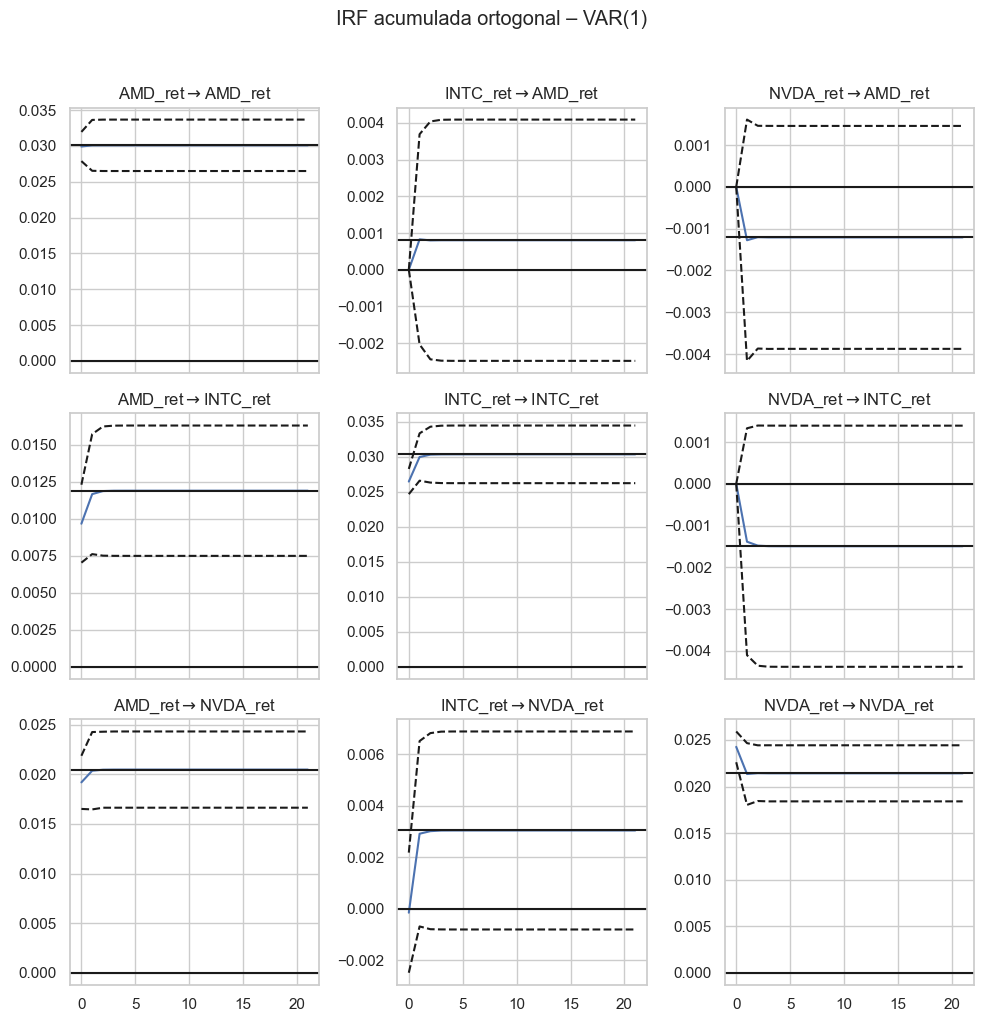

In [19]:
if 'close_b' not in globals():
    close_b = close.asfreq("B").ffill().sort_index()

if not all(k in globals() for k in ['R_train','mod_tr','p_tr','P_train']):
    idx_split = int(len(close_b) * 0.80)
    P_train = close_b.iloc[:idx_split].copy()
    R_train = np.log(P_train).diff().dropna()
    R_train.columns = [f"{c}_ret" for c in R_train.columns]

    mod_tr = VAR(R_train).fit(maxlags=15, ic="aic", trend="c")
    p_tr = max(1, int(mod_tr.k_ar))
    if mod_tr.k_ar == 0:
        mod_tr = VAR(R_train).fit(p_tr, trend="c")


h = 21


nlags = min(12, max(5, p_tr + 4))
wtest = mod_tr.test_whiteness(nlags=nlags)
print(f"=== Whiteness (Portmanteau, nlags={nlags}) ===")
print(wtest.summary())

ntest = mod_tr.test_normality()
print("\n=== Normality (JB multivariante) ===")
print(ntest.summary())

print("\nOrden VAR (Cholesky):", list(R_train.columns))

irf = mod_tr.irf(h)
fig_cum = irf.plot_cum_effects(orth=True)
fig_cum.suptitle(f"IRF acumulada ortogonal – VAR({p_tr})", y=1.02)
fig_cum.tight_layout()
plt.show()


Resultados de la IRF acumulada ortogonal (VAR(1))

La **IRF acumulada** confirma lo visto en las IRF puntuales y permite leer el **efecto neto** de cada shock en el horizonte de 21 días hábiles.

**Efectos propios (diagonal):**
- En **AMD, INTC y NVDA** el impacto acumulado de un shock **propio** es **positivo** y se **estabiliza rápido**.
- La magnitud final de los efectos propios es **claramente mayor** que la de los cruzados → la **dinámica idiosincrática domina**.

**Efectos cruzados (fuera de la diagonal):**
- Los shocks entre activos muestran **impactos pequeños** y de **corta duración**; el efecto acumulado converge a **niveles bajos**.
- El **signo** de los efectos cruzados puede ser **leve y mixto** (algunos positivos, otros cercanos a cero o ligeramente negativos), sin persistencia relevante.

**Persistencia temporal:**
- La mayor parte de la acumulación ocurre en los **primeros 2–3 días**; luego los efectos quedan **prácticamente planos**.
- No se observan trayectorias de largo plazo inducidas por shocks cruzados.

**Conclusión:**
- Los **shocks propios** determinan la trayectoria de cada activo en el corto plazo.
- Las **interacciones cruzadas** existen pero son **débiles y transitorias**.
- El sistema **absorbe rápidamente** las perturbaciones y converge a un **equilibrio** con efectos acumulados **acotados**.

**Notas técnicas:** IRF ortogonal por **Cholesky** (orden: `AMD_ret`, `INTC_ret`, `NVDA_ret`); Portmanteau sin autocorrelación remanente; normalidad multivariante no estricta (típico en retornos), por lo que los IC se interpretan con cautela.


### Descomposición de Varianza del Error de Pronóstico (FEVD)

La **FEVD (Forecast Error Variance Decomposition)** permite cuantificar qué proporción de la varianza en el error de predicción de cada variable se explica por **shocks propios** y qué proporción se debe a **shocks provenientes de otras variables**.  

Este análisis es complementario a las IRF, ya que mientras aquellas muestran la **trayectoria dinámica** de la respuesta a un shock, la FEVD resume la **importancia relativa** de cada fuente de innovación en el horizonte de pronóstico.  

En este caso, se evaluó la FEVD para un horizonte de **21 días hábiles (~1 mes)** sobre los retornos de **AMD, INTC y NVDA**, a partir de un modelo **VAR(1)**.



=== FEVD (resumen, h=21) ===
FEVD for AMD_ret
       AMD_ret  INTC_ret  NVDA_ret
0     1.000000  0.000000  0.000000
1     0.997422  0.000764  0.001814
2     0.997415  0.000765  0.001820
3     0.997415  0.000765  0.001820
4     0.997415  0.000765  0.001820
5     0.997415  0.000765  0.001820
6     0.997415  0.000765  0.001820
7     0.997415  0.000765  0.001820
8     0.997415  0.000765  0.001820
9     0.997415  0.000765  0.001820
10    0.997415  0.000765  0.001820
11    0.997415  0.000765  0.001820
12    0.997415  0.000765  0.001820
13    0.997415  0.000765  0.001820
14    0.997415  0.000765  0.001820
15    0.997415  0.000765  0.001820
16    0.997415  0.000765  0.001820
17    0.997415  0.000765  0.001820
18    0.997415  0.000765  0.001820
19    0.997415  0.000765  0.001820
20    0.997415  0.000765  0.001820

FEVD for INTC_ret
       AMD_ret  INTC_ret  NVDA_ret
0     0.117778  0.882222  0.000000
1     0.120054  0.877578  0.002368
2     0.120082  0.877539  0.002379
3     0.120083  0.877538

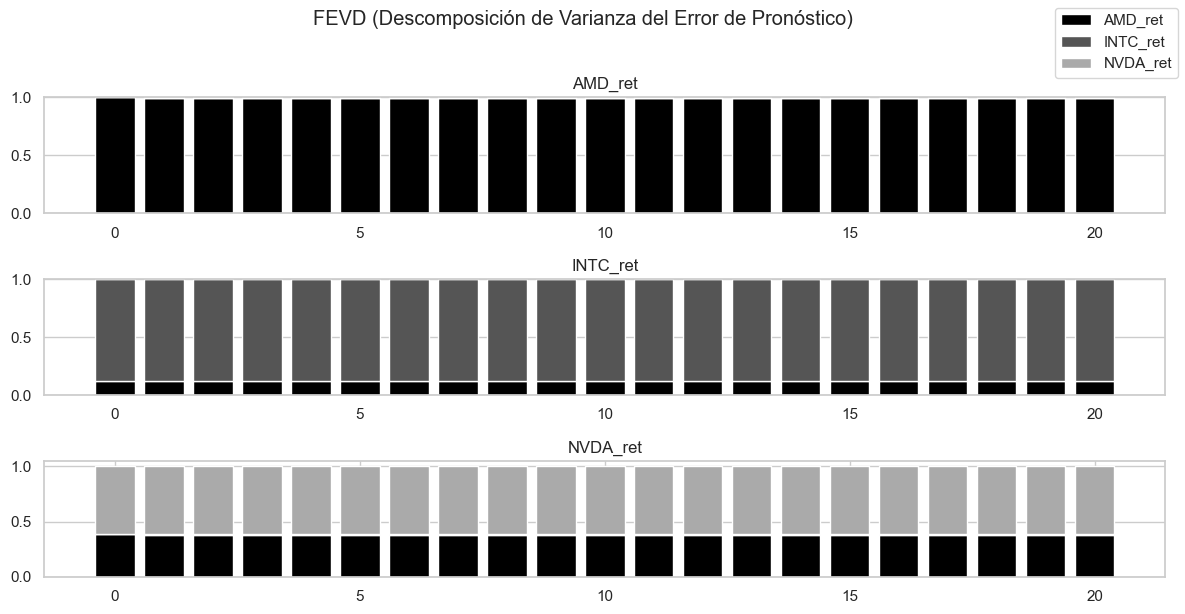

In [20]:
h = 21
fevd = mod_tr.fevd(h)

print("\n=== FEVD (resumen, h=21) ===")
print(fevd.summary())

fig_fevd = fevd.plot(figsize=(12, 6))
plt.suptitle("FEVD (Descomposición de Varianza del Error de Pronóstico)", y=1.02)
plt.tight_layout()
plt.show()

- **AMD_ret**  
  Su varianza de pronóstico es explicada casi en su totalidad por **shocks propios (>99%)**, con un aporte mínimo de INTC y NVDA.  
    Indica que **AMD es el activo más autosuficiente**, con muy poca influencia externa.

- **INTC_ret**  
  La mayor parte de su varianza se debe a shocks propios (~88%), aunque **AMD explica alrededor del 12%**.  
    Esto muestra una **interdependencia moderada**: INTC depende en cierta medida de AMD, pero conserva un comportamiento mayormente autónomo.

- **NVDA_ret**  
  Aproximadamente un **61% de su varianza** se debe a shocks propios, mientras que **AMD explica cerca del 38%**. La contribución de INTC es mínima.  
    Esto revela que **NVDA es el activo más dependiente de factores externos**, especialmente de AMD.

- **AMD actúa como transmisor dominante de shocks** dentro del sistema.  
- **INTC se mantiene relativamente independiente**, aunque con cierta exposición a AMD.  
- **NVDA es el más vulnerable a shocks externos**, confirmando un fuerte grado de dependencia hacia AMD.


### Predicción en precios con VAR

El objetivo de este bloque es evaluar la capacidad del modelo **VAR(p)** para pronosticar la evolución de los precios de **NVDA, AMD e INTC** a partir de sus retornos logarítmicos diarios.  

El procedimiento implementado se estructura en cuatro etapas:  

---

### 1. Preparación de los insumos
- Los precios se ajustan a frecuencia hábil (B) y se dividen en conjuntos de entrenamiento (80%) y prueba (20%).  
- A partir de los precios de entrenamiento se calculan los **retornos logarítmicos**, que constituyen la base para estimar el modelo.  

---

### 2. Estimación del modelo
- Se ajusta un modelo **VAR con constante** sobre los retornos.  
- El orden $p$ se selecciona mediante criterios de información (AIC, BIC, HQIC), asegurando que $p \ge 1$.  

---

### 3. Pronóstico y reconstrucción de precios
- El VAR predice los retornos en el período de prueba.  
- Dichos retornos se acumulan y se **reconstruyen en precios** mediante la relación:  

$$
\hat P_t = P_{t_0} \times \exp\!\Bigg(\sum_{k=t_0+1}^{t}\hat r_k\Bigg)
$$

donde $P_{t_0}$ corresponde al último precio del período de entrenamiento.  

---

### 4. Visualización y métricas
- Se grafican las trayectorias observadas y predichas para cada activo (train, test y predicción).  
- Se calculan métricas de error (**MSE, RMSE, MAE y MAPE**) para cuantificar el desempeño y **comparar el ajuste del VAR frente a modelos univariantes** (ej. ARIMA).  



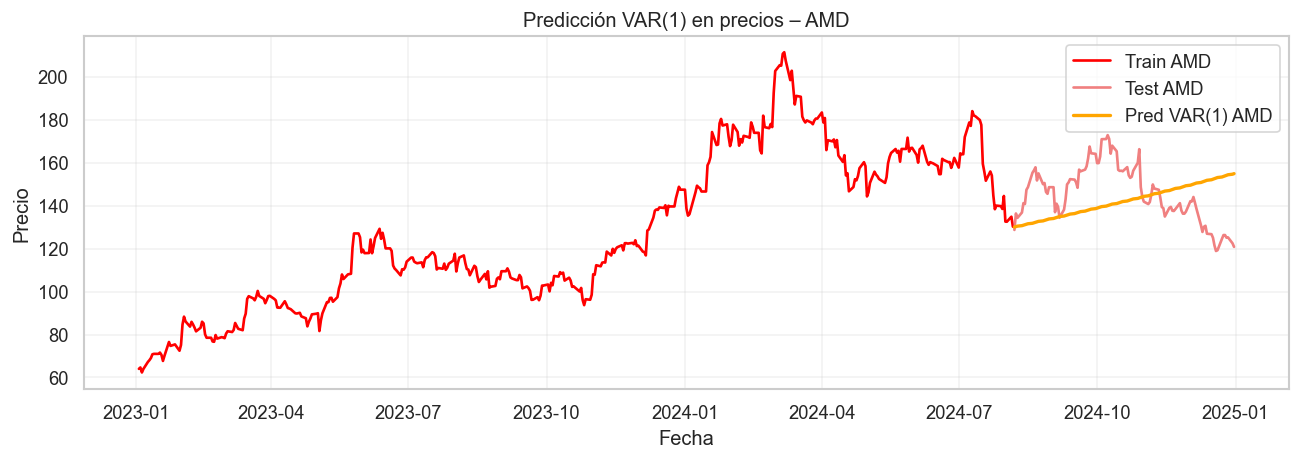

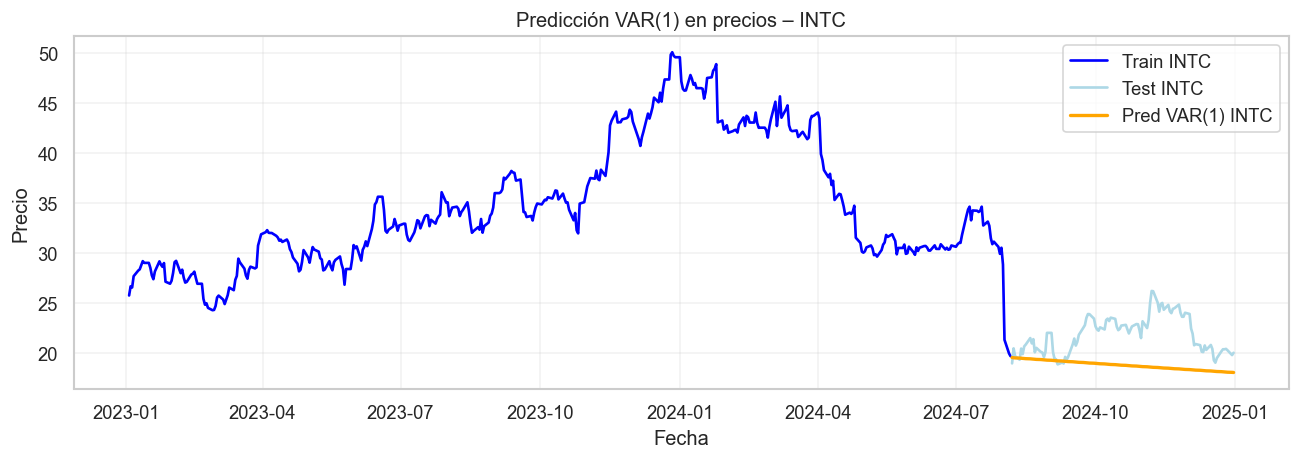

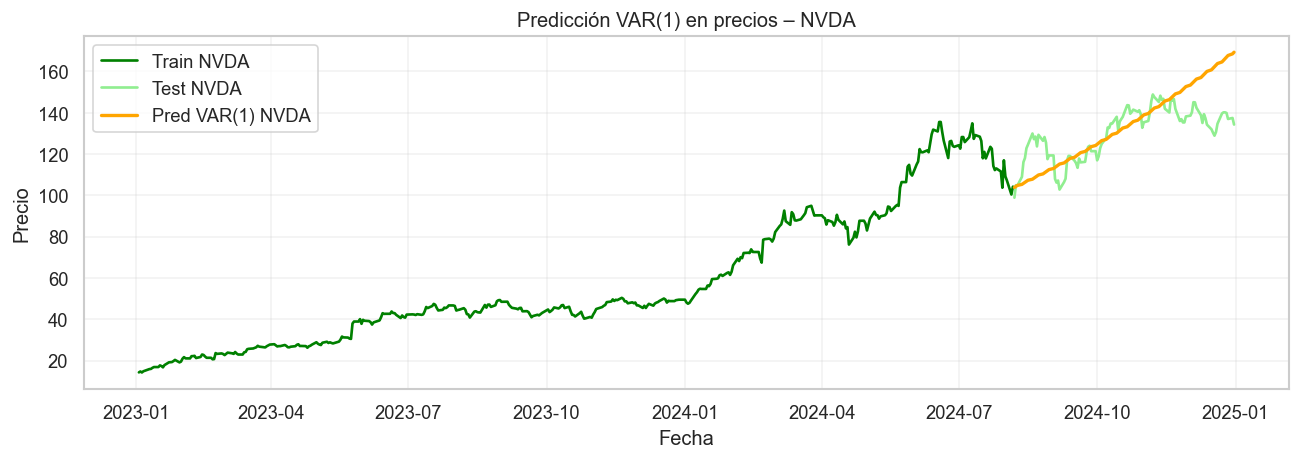


=== Métricas VAR (en precios) ===
             MSE       RMSE        MAE   MAPE
AMD   336.899426  18.354820  15.810771  10.95
INTC   13.336401   3.651904   3.088200  13.49
NVDA  190.477201  13.801348  10.306398   7.85


In [21]:
plt.rcParams["figure.dpi"] = 120

assert 'close' in globals(), "Falta 'close' (DataFrame con precios de NVDA/AMD/INTC)."
if 'close_b' not in globals():
    close_b = close.asfreq("B").ffill().sort_index()

idx_split = int(len(close_b) * 0.80)
P_train = close_b.iloc[:idx_split].copy()
P_test  = close_b.iloc[idx_split:].copy()

R_train = np.log(P_train).diff().dropna().astype("float64")
R_train.columns = [f"{c}_ret" for c in P_train.columns]

mod_tr = VAR(R_train).fit(maxlags=15, ic="aic", trend="c")
p_eff = int(mod_tr.k_ar)
if p_eff < 1:
    p_eff = 1
    mod_tr = VAR(R_train).fit(p_eff, trend="c")

n_forecast = len(P_test)
y_hist = R_train.tail(p_eff).values
fc_ret = mod_tr.forecast(y=y_hist, steps=n_forecast)
fc_ret = pd.DataFrame(fc_ret, index=P_test.index, columns=R_train.columns)

cum_ret = fc_ret.cumsum()
P0 = P_train.iloc[-1]

P_pred = pd.DataFrame(index=P_test.index, columns=P_test.columns, dtype=float)
for col in P_test.columns:
    P_pred[col] = P0[col] * np.exp(cum_ret[f"{col}_ret"])

train_color = {"NVDA": "green",   "AMD": "red",   "INTC": "blue"}
test_color  = {"NVDA": "lightgreen", "AMD": "lightcoral", "INTC": "lightblue"}
pred_color  = "orange"  # mismo color para Pred en todas

for col in P_test.columns:
    plt.figure(figsize=(11,4))
    plt.plot(P_train.index, P_train[col], label=f"Train {col}", color=train_color[col], lw=1.6)
    plt.plot(P_test.index,  P_test[col],  label=f"Test {col}",  color=test_color[col],  lw=1.6)
    plt.plot(P_pred.index,  P_pred[col],  label=f"Pred VAR({p_eff}) {col}", color=pred_color, lw=2.0)
    plt.title(f"Predicción VAR({p_eff}) en precios – {col}")
    plt.xlabel("Fecha"); plt.ylabel("Precio")
    plt.legend(); plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

def mape(y_true, y_pred, eps=1e-8):
    y = np.asarray(y_true, float); yhat = np.asarray(y_pred, float)
    mask = np.abs(y) > eps
    return float(np.mean(np.abs((y[mask] - yhat[mask]) / y[mask])) * 100)

def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    return {"MSE": float(mse), "RMSE": float(rmse), "MAE": float(mae), "MAPE": round(mape(y_true, y_pred), 2)}

metricas_var = (pd.DataFrame({
    col: compute_metrics(P_test[col], P_pred[col]) for col in P_test.columns
}).T.loc[list(P_test.columns)].round({"MSE":6,"RMSE":6,"MAE":6}))

print("\n=== Métricas VAR (en precios) ===")
print(metricas_var)



### Resultados de predicción con VAR(1)

Tras estimar el modelo **VAR(1)** sobre los **retornos logarítmicos** de **NVDA, AMD e INTC**, se reconstruyeron los precios y se evaluaron las predicciones en el conjunto de prueba (20% final de la muestra). Los resultados se presentan en las siguientes gráficas y en la tabla de métricas.

### Predicciones gráficas
- **NVDA (rojo):**  
  La predicción (línea naranja) proyecta una tendencia alcista casi lineal, mientras que los precios reales de prueba exhiben mayor volatilidad y fluctuaciones bruscas. El VAR capta la dirección general pero no reproduce la dinámica de alta variabilidad.  

- **AMD (azul):**  
  La predicción suaviza excesivamente la trayectoria, con un sesgo levemente alcista, sin capturar las caídas pronunciadas en el período de prueba. Esto refleja la tendencia del VAR a **subestimar la volatilidad** en activos más inestables.  

- **INTC (verde):**  
  La predicción muestra un leve descenso suave, mientras que los precios reales tienen una caída más marcada y oscilaciones adicionales. El modelo solo recoge parcialmente la tendencia bajista observada.  

---

### Métricas de desempeño
| Activo | MSE    | RMSE  | MAE   | MAPE   |
|--------|--------|-------|-------|--------|
| NVDA   | 190.48 | 13.80 | 10.31 | 7.85%  |
| AMD    | 336.90 | 18.35 | 15.81 | 10.95% |
| INTC   | 13.34  | 3.65  | 3.09  | 13.49% |

- **NVDA:** obtiene un **MAPE de 7.9%**, indicando un error relativo moderado. El modelo capta la tendencia promedio, aunque simplifica en exceso la dinámica real.  
- **AMD:** presenta el peor desempeño (**MAPE ≈ 11%**), ya que el modelo no reproduce las caídas recientes en los precios y sobreestima la estabilidad.  
- **INTC:** los errores absolutos son bajos (MAE ≈ 3), pero el **MAPE llega a 13.5%** porque los precios son relativamente bajos, lo que magnifica el error relativo.  

---

### Síntesis
- El **VAR(1) resulta más adecuado para activos con trayectorias relativamente estables**, como **NVDA**, donde logra aproximar la tendencia general.  
- En activos volátiles como **AMD**, el modelo suaviza demasiado y pierde capacidad de ajuste.  
- Para **INTC**, la baja escala de precios hace que los errores relativos se vean amplificados.  
- En general, el VAR aplicado sobre precios reconstruidos muestra limitaciones para capturar **shocks y variabilidad de corto plazo**, lo que refuerza la conveniencia de trabajar directamente en **retornos** para mejorar la estacionariedad y el ajuste.  



### Causalidad de Granger y mapa de calor (heatmap)

Para complementar el VAR(1), evaluamos **causalidad de Granger** entre los **retornos logarítmicos** de NVDA, AMD e INTC usando la muestra de **entrenamiento**.  
La causalidad de Granger no implica causalidad “verdadera”; contrasta si los rezagos de una serie **aportan información predictiva** adicional sobre otra, **condicional** a los propios rezagos de la serie dependiente.

- **Base:** `R_train` (retornos) — condición necesaria de estacionariedad para Granger.  
- **Rezagos:** `maxlag = p_tr` (el mismo orden seleccionado para el VAR), recorriendo `1..p_tr`.  
- **Prueba:** `ssr_chi2test` de `statsmodels.grangercausalitytests`.  
- **Matriz de p-valores:** para cada par (fila = respondida _y_, columna = causante _x_) guardamos el **p-valor mínimo** entre los lags 1..`p_tr`. La diagonal se deja en `NaN` (no aplica).

- Cada celda muestra el **p-valor mínimo** de la prueba *“x Granger-causa a y”*.  
- **Valores bajos (p < 0.05)** sugieren **evidencia estadística** de que los rezagos de _x_ ayudan a predecir _y_.  
- El color de la escala (“viridis”) pasa de **oscuro (p bajo)** a **claro (p alto)**.

- El resultado es **direccional**: “NVDA → AMD” no implica “AMD → NVDA”.  
- Puede existir **sensibilidad al número de rezagos**; por eso se recorre 1..`p_tr` y se reporta el mínimo.  
- Si se realizan muchas comparaciones, conviene considerar un ajuste por **múltiples tests** (p. ej., Bonferroni o FDR) si se va a concluir con un umbral estricto de significancia.  
- La interpretación es más robusta cuando es **consistente** con los **coeficientes del VAR** y con las **IRF**.




=== Granger (p-val mínimos; base: retornos TRAIN) ===
          AMD_ret  INTC_ret  NVDA_ret
AMD_ret       NaN    0.5816    0.3884
INTC_ret   0.6315       NaN    0.6047
NVDA_ret   0.0774    0.0152       NaN


/Users/paul/Downloads/Documentos Locales/AST_MCD_E10/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/paul/Downloads/Documentos Locales/AST_MCD_E10/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/paul/Downloads/Documentos Locales/AST_MCD_E10/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/paul/Downloads/Documentos Locales/AST_MCD_E10/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/paul/Downloads/Documentos Locales/AST_MCD_E10/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: Futur

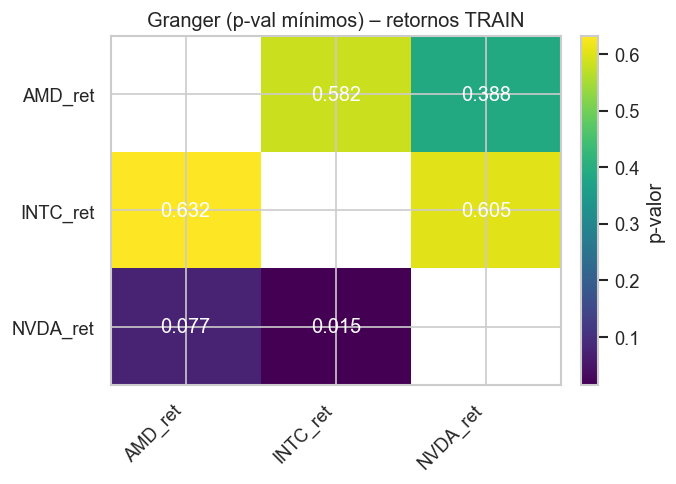

In [22]:
def grangers_causation_matrix(data, variables, maxlag=1, test='ssr_chi2test'):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))),
                      columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            if r == c:
                df.loc[r, c] = np.nan
                continue
            res = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            pvals = [res[i+1][0][test][1] for i in range(maxlag)]
            df.loc[r, c] = np.min(pvals)
    return df

gmat = grangers_causation_matrix(R_train,
                                 variables=list(R_train.columns),
                                 maxlag=p_tr,
                                 test='ssr_chi2test')
print("\n=== Granger (p-val mínimos; base: retornos TRAIN) ===")
print(gmat.round(4))

fig = plt.figure(figsize=(5.8, 4.2))
arr = gmat.values.astype(float)
im = plt.imshow(arr, cmap="viridis", aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04, label="p-valor")
plt.xticks(ticks=range(len(gmat.columns)), labels=gmat.columns, rotation=45, ha="right")
plt.yticks(ticks=range(len(gmat.index)),   labels=gmat.index)
plt.title("Granger (p-val mínimos) – retornos TRAIN")

for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        txt = "" if np.isnan(arr[i, j]) else f"{arr[i, j]:.3f}"
        plt.text(j, i, txt, ha="center", va="center", color="white")
plt.tight_layout()

plt.show()

El análisis de causalidad de Granger se aplicó sobre los **retornos logarítmicos** de NVDA, AMD e INTC, utilizando la muestra de entrenamiento y un máximo de `p_tr` rezagos.  
La matriz muestra los **p-valores mínimos** para cada relación direccional (_columna → fila_).

- **NVDA_ret → INTC_ret (p = 0.015)**  
  Existe **evidencia estadísticamente significativa (p < 0.05)** de que los retornos de NVDA ayudan a predecir los retornos de INTC.  
  Esto sugiere un efecto de transmisión desde NVDA hacia INTC.

- **NVDA_ret → AMD_ret (p = 0.077)**  
  Aunque no alcanza el umbral del 5%, el p-valor relativamente bajo sugiere una **posible influencia** de NVDA sobre AMD.  
  Podría ser considerado marginalmente relevante con un nivel de significancia más laxo (10%).

- **INTC_ret → AMD_ret (p = 0.632)** y **AMD_ret → INTC_ret (p = 0.582)**  
  No se observa evidencia de causalidad de Granger. Los retornos de una no aportan información predictiva adicional sobre la otra.

- **AMD_ret → NVDA_ret (p = 0.388)** e **INTC_ret → NVDA_ret (p = 0.605)**  
  Tampoco se encuentra causalidad significativa de AMD o INTC hacia NVDA. Esto indica que NVDA actúa más como **emisor de información** que como receptor en este sistema.

- NVDA muestra un rol **predominante**, siendo la única serie cuyos retornos parecen tener poder predictivo sobre otra (especialmente sobre INTC).  
- Las demás relaciones muestran **p-valores altos**, lo que indica ausencia de causalidad de Granger estadísticamente significativa.  
- El heatmap facilita la visualización: los tonos más oscuros (p bajos) resaltan la dirección NVDA → INTC como la más relevante.



## <span id="comparativa"></span> Comparativa ARIMA vs VAR

Con el objetivo de evaluar la capacidad predictiva de distintos enfoques, se plantea una **comparativa entre modelos ARIMA y VAR** aplicados a las series de precios de NVDA, AMD e INTC.  
La idea es disponer de una tabla conjunta de métricas de error (MSE, RMSE, MAE y MAPE) que permita analizar cuál de los modelos ofrece un mejor ajuste y mayor precisión en el horizonte de prueba.  
Este bloque del análisis está diseñado para unir las métricas de ambos modelos, resaltando los valores más bajos como los más adecuados en términos de desempeño.

In [23]:
if 'metricas_arima' in globals():
    comp = (metricas_arima.add_suffix("_ARIMA")
            .join(metricas_var.add_suffix("_VAR")))
  
    def best_mark(df, cols, lower_is_better=True):
        out = df.copy()
        for c in cols:
            v = out[c]
            idx = v.idxmin() if lower_is_better else v.idxmax()
            out.loc[idx, c] = f"**{v.loc[idx]:.4f}**" if c.endswith("MAPE_VAR") else f"**{v.loc[idx]}**"
        return out
    cols_eval = [c for c in comp.columns if any(k in c for k in ["MSE","RMSE","MAE","MAPE"])]
    print("\n=== Comparativa ARIMA vs VAR (MSE/RMSE/MAE/MAPE) ===")
    print(comp)
else:
    print("\n[Info] No encuentro 'metricas_arima'. Saltando comparativa.")


=== Comparativa ARIMA vs VAR (MSE/RMSE/MAE/MAPE) ===
       MSE_ARIMA  RMSE_ARIMA  MAE_ARIMA  MAPE_ARIMA     MSE_VAR   RMSE_VAR  \
NVDA  369.484877   19.221989  17.324497       12.89  190.477201  13.801348   
AMD   480.355562   21.917015  18.827962       12.30  336.899426  18.354820   
INTC   12.143846    3.484802   2.965306       12.91   13.336401   3.651904   

        MAE_VAR  MAPE_VAR  
NVDA  10.306398      7.85  
AMD   15.810771     10.95  
INTC   3.088200     13.49  


La tabla muestra las métricas de error (MSE, RMSE, MAE y MAPE) obtenidas en el conjunto 
de prueba para cada acción (NVDA, AMD e INTC), contrastando los modelos **ARIMA** 
(univariados) frente al modelo **VAR** (multivariado).

- **NVDA**  
  - El VAR obtiene errores claramente menores (MSE ≈ 190 vs 369, MAE ≈ 10.3 vs 17.3, MAPE 7.85% vs 12.9%).  
  - Esto indica que la dinámica de NVDA se explica mejor al considerar simultáneamente la información de AMD e INTC.  

- **AMD**  
  - Nuevamente, el VAR supera al ARIMA en todas las métricas (MSE 336 vs 480, MAPE 10.95% vs 12.3%).  
  - Al igual que NVDA, AMD se beneficia del enfoque multivariado que capta relaciones cruzadas.  

- **INTC**  
  - Los resultados son más parejos: el ARIMA obtiene un MSE ligeramente inferior (12.1 vs 13.3) y un MAPE similar (12.9% vs 13.5%).  
  - Aquí no hay una ventaja clara del VAR, lo que sugiere que INTC puede comportarse de manera más autónoma respecto a NVDA y AMD.  

- Para **NVDA y AMD**, el modelo **VAR** ofrece mayor precisión predictiva.  
- Para **INTC**, el desempeño de ARIMA y VAR es comparable.  
- Esto respalda la utilidad de los modelos multivariados en mercados con fuerte interdependencia entre activos.



## <span id="automl"></span> AutoML - Flaml

In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

TARGET_COL = "Close"  
N_SPLITS_CV = 5       

# Métricas
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_true_safe = np.where(np.abs(y_true) < epsilon, epsilon, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

def compute_metrics(y_true, y_pred):
    return {
        "MAE":  mean_absolute_error(y_true, y_pred),
        "MSE":  mean_squared_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
    }

# Features de fecha 
def to_df_with_target(obj, target_col=TARGET_COL):
    """Asegura DataFrame con la columna target_col y índice datetime."""
    if isinstance(obj, pd.Series):
        df = obj.to_frame(name=target_col)
    else:
        df = obj.copy()
        if df.shape[1] == 1 and target_col not in df.columns:
            df.columns = [target_col]
        elif target_col not in df.columns:
            raise ValueError(f"No encuentro '{target_col}' en columnas: {df.columns.tolist()}")
    # índice datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    return df

def create_date_features(df):
    df = df.copy()
    # Todas NUMÉRICAS, aptas para modelos
    df["dayofweek"]      = df.index.dayofweek
    df["month"]          = df.index.month
    df["quarter"]        = df.index.quarter
    df["dayofmonth"]     = df.index.day
    df["dayofyear"]      = df.index.dayofyear
    df["is_month_start"] = df.index.is_month_start.astype(int)
    df["is_month_end"]   = df.index.is_month_end.astype(int)
    return df

def prepare_date_only_supervised(train_series, test_series, target_col=TARGET_COL):
    """Devuelve X_train, y_train, X_test, y_test usando SOLO features de fecha."""
    tr = to_df_with_target(train_series, target_col=target_col)
    te = to_df_with_target(test_series,  target_col=target_col)

    tr = create_date_features(tr)
    te = create_date_features(te)

    X_train = tr.drop(columns=[target_col])
    y_train = tr[target_col].copy()
    X_test  = te.drop(columns=[target_col])
    y_test  = te[target_col].copy()
    return X_train, y_train, X_test, y_test


In [25]:
# NVDA
X_train_nvda, y_train_nvda, X_test_nvda, y_test_nvda = prepare_date_only_supervised(nvda_train, nvda_test, TARGET_COL)

# AMD
X_train_amd,  y_train_amd,  X_test_amd,  y_test_amd  = prepare_date_only_supervised(amd_train,  amd_test,  TARGET_COL)

# INTC
X_train_intc, y_train_intc, X_test_intc, y_test_intc = prepare_date_only_supervised(intel_train, intel_test, TARGET_COL)



In [27]:
from flaml import AutoML

automl_nvda = AutoML()
automl_nvda.fit(
    X_train=X_train_nvda,
    y_train=y_train_nvda,
    task="regression",
    metric="rmse",
    time_budget=300,      # 5 minutos
    estimator_list=["lgbm","xgboost","rf","extra_tree"],
    n_jobs=-1,
    seed=42,
    eval_method="cv"
)

print("Entrenamiento NVDA finalizado")
print("Mejor modelo:", automl_nvda.best_estimator)

y_pred_nvda = automl_nvda.predict(X_test_nvda)
FLAML_METRICS_NVDA = compute_metrics(y_test_nvda, y_pred_nvda)
print("Métricas NVDA:", FLAML_METRICS_NVDA)


[flaml.automl.logger: 10-06 23:31:46] {1752} INFO - task = regression
[flaml.automl.logger: 10-06 23:31:46] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 10-06 23:31:46] {1862} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 10-06 23:31:46] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf', 'extra_tree']
[flaml.automl.logger: 10-06 23:31:46] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-06 23:31:46] {2417} INFO - Estimated sufficient time budget=588s. Estimated necessary time budget=1s.
[flaml.automl.logger: 10-06 23:31:46] {2466} INFO -  at 0.1s,	estimator lgbm's best error=30.1047,	best estimator lgbm's best error=30.1047
[flaml.automl.logger: 10-06 23:31:46] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-06 23:31:46] {2466} INFO -  at 0.2s,	estimator lgbm's best error=30.1047,	best estimator lgbm's best error=30.1047
[flaml.automl.logger: 10-06 23:31:46] {2282} INFO - iteration 2, cur

Mejor modelo: extra_tree

Métricas NVDA: {'MAE': 82.06857148204445, 'MSE': 6935.896547597937, 'RMSE': 83.28203016016082, 'MAPE': 62.45883476120658}

In [28]:
import joblib

joblib.dump(automl_nvda, "automl_nvda.pkl")

['automl_nvda.pkl']

In [29]:
automl_amd = AutoML()
automl_amd.fit(
    X_train=X_train_amd,
    y_train=y_train_amd,
    task="regression",
    metric="rmse",
    time_budget=300,      # 5 min
    estimator_list=["lgbm","xgboost","rf","extra_tree"],
    n_jobs=-1,
    seed=42,
    eval_method="cv"
)

print("Entrenamiento AMD finalizado")
print("Mejor modelo:", automl_amd.best_estimator)

y_pred_amd = automl_amd.predict(X_test_amd)
FLAML_METRICS_AMD = compute_metrics(y_test_amd, y_pred_amd)
print("Métricas AMD:", FLAML_METRICS_AMD)


[flaml.automl.logger: 10-06 23:45:47] {1752} INFO - task = regression
[flaml.automl.logger: 10-06 23:45:47] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 10-06 23:45:47] {1862} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 10-06 23:45:47] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf', 'extra_tree']
[flaml.automl.logger: 10-06 23:45:47] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-06 23:45:47] {2417} INFO - Estimated sufficient time budget=507s. Estimated necessary time budget=1s.
[flaml.automl.logger: 10-06 23:45:47] {2466} INFO -  at 0.1s,	estimator lgbm's best error=34.1470,	best estimator lgbm's best error=34.1470
[flaml.automl.logger: 10-06 23:45:47] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-06 23:45:47] {2466} INFO -  at 0.1s,	estimator lgbm's best error=34.1470,	best estimator lgbm's best error=34.1470
[flaml.automl.logger: 10-06 23:45:47] {2282} INFO - iteration 2, cur

Mejor modelo: lgbm

Métricas AMD: {'MAE': 30.43648936782668, 'MSE': 1234.0382404485904, 'RMSE': 35.128880432609726, 'MAPE': 19.99448731253905}

In [30]:
joblib.dump(automl_amd, "automl_amd.pkl")

['automl_amd.pkl']

In [31]:
automl_intc = AutoML()
automl_intc.fit(
    X_train=X_train_intc,
    y_train=y_train_intc,
    task="regression",
    metric="rmse",
    time_budget=300,      # 5 min
    estimator_list=["lgbm","xgboost","rf","extra_tree"],
    n_jobs=-1,
    seed=42,
    eval_method="cv"
)

print("Entrenamiento INTC finalizado")
print("Mejor modelo:", automl_intc.best_estimator)

y_pred_intc = automl_intc.predict(X_test_intc)
FLAML_METRICS_INTC = compute_metrics(y_test_intc, y_pred_intc)
print("Métricas INTC:", FLAML_METRICS_INTC)


[flaml.automl.logger: 10-06 23:50:48] {1752} INFO - task = regression
[flaml.automl.logger: 10-06 23:50:48] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 10-06 23:50:48] {1862} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 10-06 23:50:48] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf', 'extra_tree']
[flaml.automl.logger: 10-06 23:50:48] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-06 23:50:48] {2417} INFO - Estimated sufficient time budget=601s. Estimated necessary time budget=1s.
[flaml.automl.logger: 10-06 23:50:48] {2466} INFO -  at 0.1s,	estimator lgbm's best error=5.7779,	best estimator lgbm's best error=5.7779
[flaml.automl.logger: 10-06 23:50:48] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-06 23:50:48] {2466} INFO -  at 0.1s,	estimator lgbm's best error=5.7779,	best estimator lgbm's best error=5.7779
[flaml.automl.logger: 10-06 23:50:48] {2282} INFO - iteration 2, current

Mejor modelo: lgbm

Métricas INTC: {'MAE': 15.78109196110557, 'MSE': 267.4165587505682, 'RMSE': 16.35287616141479, 'MAPE': 73.12204824121524}

In [32]:
joblib.dump(automl_intc, "automl_intc.pkl")

['automl_intc.pkl']

## <span id="timegpt"></span> TimeGPT

In [37]:
from nixtla import NixtlaClient
import os
from dotenv import load_dotenv

load_dotenv()
nixtla_client = NixtlaClient(api_key=os.environ.get("NIXTLA_API_KEY"))

In [38]:
TIME_COL   = "Date" 
TARGET_COL = "Close"    

In [41]:
def as_timegpt_df(df_or_series):
    """
    Acepta:
      - DataFrame con columnas TIME_COL y TARGET_COL
      - Serie con índice datetime
    Devuelve df con columnas [TIME_COL, TARGET_COL], ordenado y sin NaN.
    """
    if isinstance(df_or_series, pd.Series):
        df = df_or_series.reset_index()
        df.columns = [TIME_COL, TARGET_COL]
    else:
        df = df_or_series.copy()
        if TIME_COL not in df.columns:
            # si el tiempo está en el índice, lo bajamos a columna
            df = df.reset_index().rename(columns={"index": TIME_COL})
        # nos quedamos solo con las 2 col necesarias (y en ese orden)
        df = df[[TIME_COL, TARGET_COL]]
    # orden temporal + limpieza mínima
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    df = df.sort_values(TIME_COL).dropna(subset=[TARGET_COL])
    return df

# Corre TimeGPT y evalúa contra el test 
def run_timegpt(train_df_like, test_df_like, label, freq=None, model="timegpt-1"):
    """
    train_df_like/test_df_like: DataFrame o Serie. Deben contener TARGET_COL.
    label: nombre de la serie (NVDA, AMD, INTC)
    freq: None (infiere) o "B" para días hábiles (útil para acciones)
    """
    df_train = as_timegpt_df(train_df_like)
    df_test  = as_timegpt_df(test_df_like)

    h = len(df_test)  # horizonte = tamaño del set de test

    fcst = nixtla_client.forecast(
        df=df_train,
        h=h,
        time_col=TIME_COL,
        target_col=TARGET_COL,
        freq=freq,            # usa "B" si querés forzar días hábiles
        model=model
    )

    # Columna de predicción puntual (por lo general "TimeGPT")
    point_col = "TimeGPT" if "TimeGPT" in fcst.columns else fcst.columns[-1]
    y_pred = fcst[point_col].to_numpy()

    # y_true del test
    y_true = df_test[TARGET_COL].to_numpy(dtype=float)

    mets = compute_metrics(y_true, y_pred)
    print(f"{label}: {mets} | Best model={model}")
    return fcst, mets

# NVDA
nvda_fcst_df, TIMEGPT_METRICS_NVDA = run_timegpt(
    nvda_train, nvda_test, label="NVDA", freq="B", model="timegpt-1"
)


# AMD
amd_fcst_df, TIMEGPT_METRICS_AMD = run_timegpt(
    amd_train, amd_test, label="AMD", freq="B", model="timegpt-1"
)


# INTC
intel_fcst_df, TIMEGPT_METRICS_INTC = run_timegpt(
    intel_train, intel_test, label="INTC", freq="B", model="timegpt-1"
)

# Comparativo final 
timegpt_results = pd.DataFrame([
    {"Serie": "NVDA", **TIMEGPT_METRICS_NVDA},
    {"Serie": "AMD",  **TIMEGPT_METRICS_AMD},
    {"Serie": "INTC", **TIMEGPT_METRICS_INTC},
]).sort_values("Serie").reset_index(drop=True)

timegpt_results

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


NVDA: {'MAE': 26.165803589079907, 'MSE': 827.3660634073575, 'RMSE': 28.763971620889865, 'MAPE': 19.34254756961916} | Best model=timegpt-1


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


AMD: {'MAE': 18.123009065850287, 'MSE': 455.02255932948344, 'RMSE': 21.331257799986467, 'MAPE': 11.867118933905815} | Best model=timegpt-1
INTC: {'MAE': 1.497906483718721, 'MSE': 3.1728906555440224, 'RMSE': 1.7812609734522402, 'MAPE': 6.696794036139139} | Best model=timegpt-1


Serie        MAE         MSE       RMSE       MAPE
0   AMD  18.123009  455.022559  21.331258  11.867119
1  INTC   1.497906    3.172891   1.781261   6.696794
2  NVDA  26.165804  827.366063  28.763972  19.342548

In [42]:
timegpt_results.to_csv('timegpt_results.csv', index=None)